In [1]:
#import
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.stats as scs
import os
import h5py
import datetime
from datetime import date
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings("ignore")
from statsmodels.regression.linear_model import OLS
import random
import math
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from scipy import stats
import pickle

C:\Users\bj\Anaconda2\envs\Python3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\bj\Anaconda2\envs\Python3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#data
os.chdir(r'C:\Users\bj\Desktop\刘泽丹\Code')
zzIcData = pd.read_csv('zz500_from_db.csv')
zzIcData.columns = [int(i) for i in zzIcData.columns]
zzIcData[1] = [int(str(date.fromordinal(int(i)-366)).replace('-','')) for i in zzIcData[1]]
zzIcData.set_index(1,inplace=True)
zz500 = ((zzIcData[5]/zzIcData[5].shift(1)-1)*100).dropna()
full_oc = pd.read_csv('full_oc.csv',index_col=[0,1])
full_cc = pd.read_csv('full_cc.csv',index_col=[0,1])
full_amt = pd.read_csv('full_amt.csv',index_col=[0,1])
full_oc_for_remove = pd.read_csv('full_oc_for_remove.csv',index_col=[0])
full_cc_for_remove = pd.read_csv('full_cc_for_remove.csv',index_col=[0])
full_amt_for_remove = pd.read_csv('full_amt_for_remove.csv',index_col=[0])
full_cc_for_remove.dropna(how='all',inplace=True)
full_cc_for_remove.index.name = 'date'
os.chdir(r'C:\Users\bj\Desktop\刘泽丹\Code')
close = pd.read_csv('close.csv',index_col=0)
close.columns = [int(i) for i in close.columns]
adjfactor = pd.read_csv('adjfactor.csv',index_col=0)
adjfactor.columns = [int(i) for i in adjfactor.columns]
amt = pd.read_csv('amt.csv',index_col=0)
amt.columns = [int(i) for i in amt.columns]
adjclose = close * adjfactor
log_ret = adjclose/adjclose.shift(1)
pct_ret = (adjclose/adjclose.shift(1) - 1)
def process_ret(df):
    trading_dates = amt[df.name].replace(0,np.nan).dropna().index.tolist()
    return df.loc[trading_dates]
log_ret = log_ret.apply(process_ret).dropna(how='all')
pct_ret = pct_ret.apply(process_ret).dropna(how='all')

def process(df):
    if len(df.dropna(how='all')) == 0:
        return
    sub = full_cc_for_remove.iloc[full_cc_for_remove.index.tolist().index(df.index[0])+1-100:\
                                  full_cc_for_remove.index.tolist().index(df.index[0])+1]
    if len(sub) == 0:
        return
    sub = sub.T.dropna().T
    keep = []
    for i in list(sub):
        if (sub[i] == 0).sum() != len(sub):
            keep.append(i)
    sub = sub.loc[:,keep]
    return pd.DataFrame(np.corrcoef(sub.T).mean(axis=0),index = sub.columns).T
full_corr_factor = full_cc_for_remove.groupby(level='date').apply(process)

full_corr_factor.columns = [int(i) for i in full_corr_factor.columns]
full_corr_factor = full_corr_factor.T.sort_index().T

full_corr_factor.to_csv('full_corr_factor.csv')

n_days = 5
corr_dict = {}
for i in range(len(pct_ret)):
    sub = pct_ret.iloc[i+1-n_days:i+1]
    sub = sub.dropna(how='all')
    sub = sub.T.dropna().T
    if len(sub) < n_days:
        continue
    else:
        keep = []
        for i in list(sub):
            if (sub[i] == 0).sum() != len(sub):
                keep.append(i)
        sub = sub.loc[:,keep]
        corr_dict[sub.index[-1]] = (np.corrcoef(sub.T).sum() - len(list(sub)))/np.sum(range(len(list(sub))))/2
corr = pd.DataFrame.from_dict(corr_dict, orient='index')[0]
plot_df = pd.concat([(zz500/100+1).cumprod(),zz500.rolling(window=n_days).std(),corr],axis=1).dropna()
plot_df.columns = ['zz500','std','corr']
plot_df['ret'] = zz500.loc[plot_df.index]
plot_df['corr_ret'] = (plot_df['corr']/plot_df['corr'].shift(1) - 1)*100
plot_df['std_ret'] = (plot_df['std']/plot_df['std'].shift(1) - 1)*100
plot_df['yester_corr_ret'] = plot_df['corr_ret'].shift(1)
plot_df['yester_std_ret'] = plot_df['std_ret'].shift(1)
plot_df.dropna(inplace=True)

fig = plt.figure(figsize = (16,6))
ax1 = fig.add_axes([0,0.33,1,0.5])
ax1.plot(plot_df['zz500'].tolist())
ax2 = fig.add_axes([0,0,1,0.25])
ax2.plot(plot_df['std'].tolist(),'b')
ax3 = ax2.twinx()
ax3.plot(plot_df['corr'].tolist(),'g')
plt.show()

plot_df.corr()

plot_df

a,b,loc,scale = stats.johnsonsb.fit(plot_df['corr'])
num_bins = 200
counts, bin_edges = np.histogram(plot_df['corr'], bins=num_bins)
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=10000), bins=num_bins)
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.show()

In [3]:
zz500members = pd.read_csv('zz500members.csv',index_col=0)
zz500members.columns = [int(i) for i in zz500members.columns]
zz500members = zz500members.T

full_corr = {}
for n_days in [5,10,20,60,120,250]:
    corr_dict = {}
    for i in range(len(pct_ret)):
        sub = pct_ret.iloc[i+1-n_days:i+1]
        sub = sub.dropna(how='all')
        if len(sub) < n_days:
            continue
        else:
            sub = sub.loc[:,zz500members.xs(sub.index[-1]).tolist()]
            sub = sub.T.dropna().T
            keep = []
            for j in list(sub):
                if (sub[j] == 0).sum() != len(sub):
                    keep.append(j)
            sub = sub.loc[:,keep]
            corr_dict[sub.index[-1]] = (np.corrcoef(sub.T).sum() - len(list(sub)))/np.sum(range(len(list(sub))))/2
    corr = pd.DataFrame.from_dict(corr_dict, orient='index')[0]
    corr.to_csv(str(n_days)+'_zz500members_corr.csv')
    full_corr[n_days] = corr

In [4]:
full_corr = {}
for n_days in [5,10,20,60,120,250]:
    print(n_days)
    corr = pd.read_csv(str(n_days)+'_zz500members_corr.csv',header=None,index_col=0)[1]
    for i in range(len(pct_ret)):
        if pct_ret.index.tolist()[i] in corr.index:
            continue
        sub = pct_ret.iloc[i+1-n_days:i+1]
        sub = sub.dropna(how='all')
        if len(sub) < n_days:
            continue
        else:
            sub = sub.loc[:,zz500members.xs(sub.index[-1]).tolist()]
            sub = sub.T.dropna().T
            keep = []
            for i in list(sub):
                if (sub[i] == 0).sum() != len(sub):
                    keep.append(i)
            sub = sub.loc[:,keep]
            corr[sub.index[-1]] = (np.corrcoef(sub.T).sum() - len(list(sub)))/np.sum(range(len(list(sub))))/2
    corr.to_csv(str(n_days)+'_zz500members_corr.csv')
    full_corr[n_days] = corr

5
10
20
60
120
250


In [5]:
full_corr = {}
for n_days in [5,10,20,60,120,250]:
    print(n_days)
    corr = pd.read_csv(str(n_days)+'_full_corr.csv',header=None,index_col=0)[1]
    for i in range(len(pct_ret)):
        if pct_ret.index.tolist()[i] in corr.index:
            continue
        sub = pct_ret.iloc[i+1-n_days:i+1]
        sub = sub.dropna(how='all')
        sub = sub.T.dropna().T
        if len(sub) < n_days:
            continue
        else:
            keep = []
            for i in list(sub):
                if (sub[i] == 0).sum() != len(sub):
                    keep.append(i)
            sub = sub.loc[:,keep]
            corr[sub.index[-1]] = (np.corrcoef(sub.T).sum() - len(list(sub)))/np.sum(range(len(list(sub))))/2
    corr.to_csv(str(n_days)+'_full_corr.csv')
    full_corr[n_days] = corr

5
10
20
60
120
250


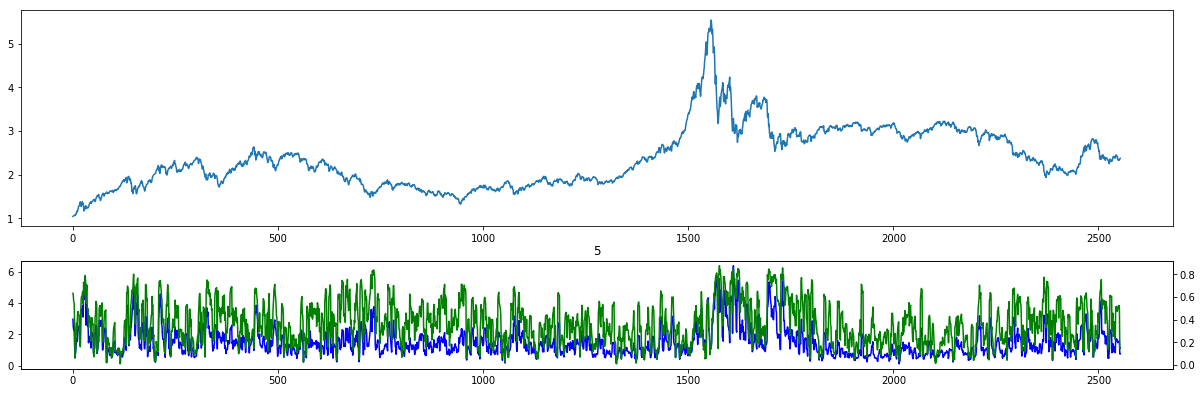

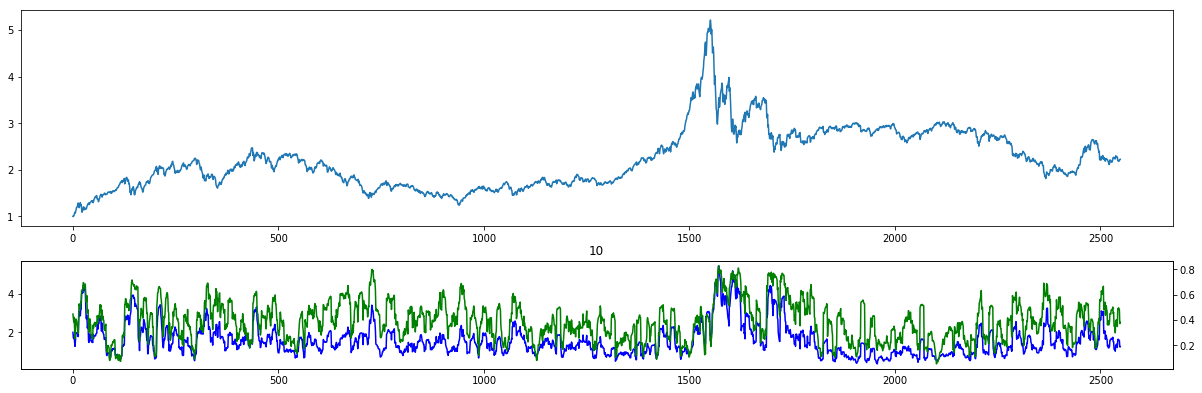

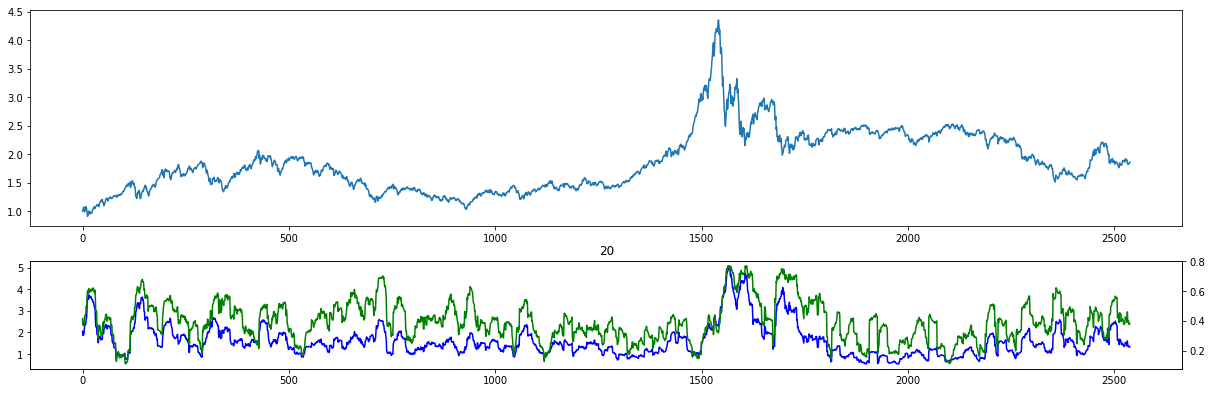

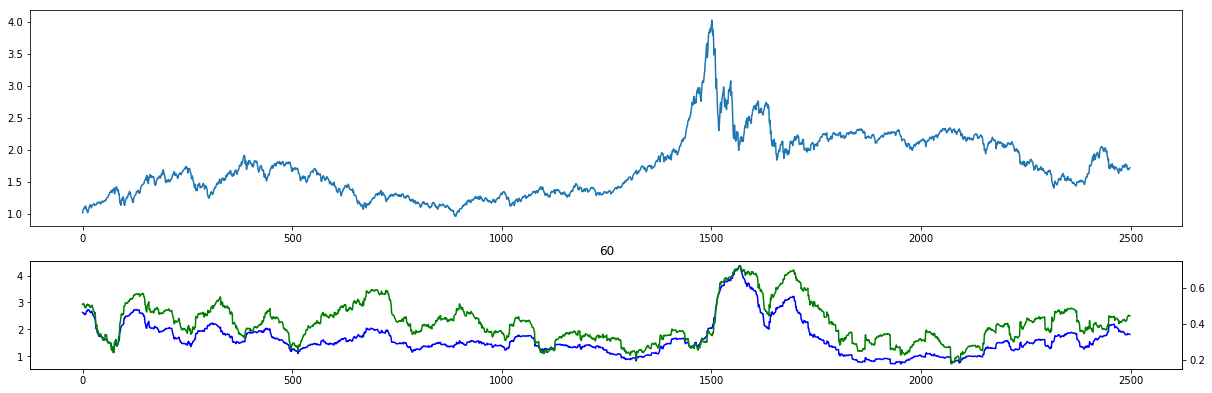

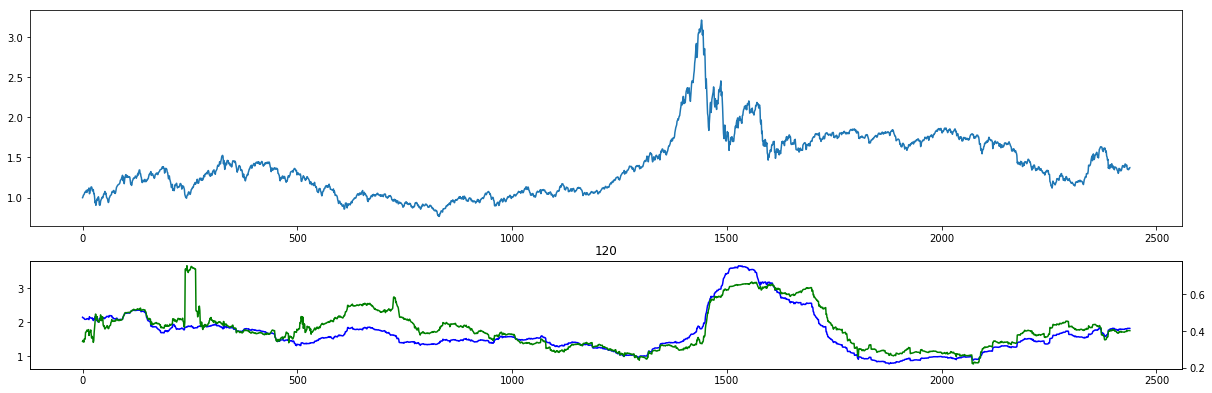

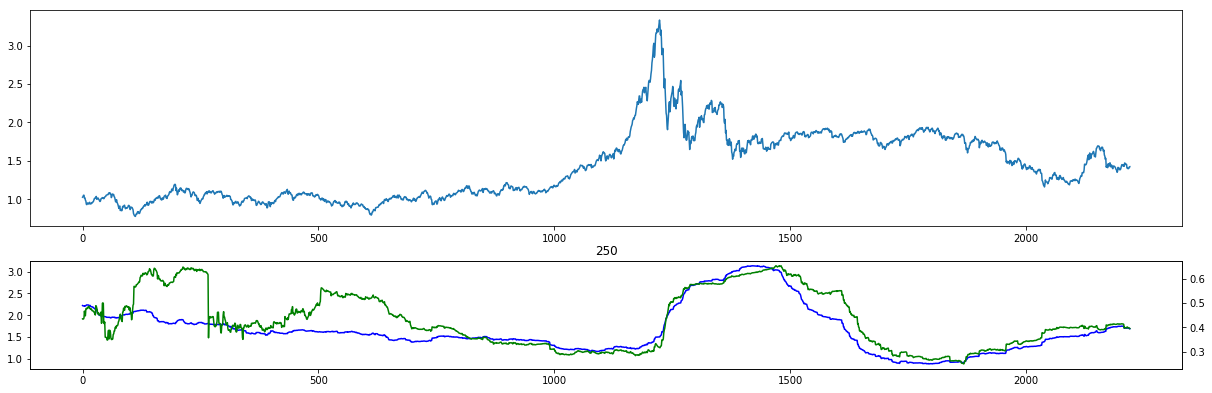

In [6]:
for key in [5,10,20,60,120,250]:
    plot_df = pd.concat([zz500,zz500.rolling(window=key).std(),full_corr[key]],axis=1).dropna()
    plot_df.columns = ['zz500','std','corr']
    plot_df['ret'] = zz500.loc[plot_df.index]
    plot_df['corr_ret'] = (plot_df['corr']/plot_df['corr'].shift(1) - 1)*100
    plot_df['std_ret'] = (plot_df['std']/plot_df['std'].shift(1) - 1)*100
    plot_df['yester_corr_ret'] = plot_df['corr_ret'].shift(1)
    plot_df['yester_std_ret'] = plot_df['std_ret'].shift(1)
    plot_df.dropna(inplace=True)
    plot_df['zz500'] = (plot_df['zz500']/100+1).cumprod()
    fig = plt.figure(figsize = (16,6))
    ax1 = fig.add_axes([0,0.33,1,0.5])
    ax1.plot(plot_df['zz500'].tolist())
    ax2 = fig.add_axes([0,0,1,0.25])
    ax2.plot(plot_df['std'].tolist(),'b')
    ax3 = ax2.twinx()
    ax3.plot(plot_df['corr'].tolist(),'g')
    plt.title(key)
    plt.show()

In [8]:
def calc_skew(data):
    n = len(data)
    niu  = 0.0
    niu2 = 0.0
    niu3 = 0.0
    for a in data:
        niu  += a
        niu2 += a**2
        niu3 += a**3
    niu  /= n
    niu2 /= n
    niu3 /= n
    sigma = math.sqrt(niu2 - niu*niu)
    skew = (niu3 - 3*niu*sigma**2 - niu**3)/(sigma**3)
    return skew

longterm_a,longterm_b,longterm_loc,longterm_scale = stats.johnsonsb.fit(full_corr[5])
def johnsonsb_sse(data, bins=101, test_a = longterm_a, test_b = longterm_b, test_loc = longterm_loc, test_scale = longterm_scale):
    y, x = np.histogram(data, bins=np.linspace(0,1,bins), density=True)
    new_x = (x + np.roll(x, -1))[:-1] / 2.0
    pdf = stats.johnsonsb.pdf(new_x, test_a, test_b, loc=test_loc, scale=test_scale,)
    sse = np.sum(np.power(y - pdf, 1.0))
    return sse

longterm_a,longterm_b,longterm_loc,longterm_scale = stats.johnsonsb.fit(full_corr[5])
def longterm_sse_lower(data, bins=101, test_a = longterm_a, test_b = longterm_b, test_loc = longterm_loc, test_scale = longterm_scale):
    y, x = np.histogram(data, bins=np.linspace(0,1,bins), density=True)
    new_x = x[:-1]
    pdf = stats.johnsonsb.pdf(new_x, test_a, test_b, loc=test_loc, scale=test_scale,)
    lowerlim = stats.johnsonsb.ppf(0.3, longterm_a, longterm_b, loc=longterm_loc, scale=longterm_scale,)
    cut = np.argwhere(new_x>lowerlim)[0][0]
    sse = np.sum(np.power(y[:cut] - pdf[:cut], 2.0))
    return sse

longterm_a,longterm_b,longterm_loc,longterm_scale = stats.johnsonsb.fit(full_corr[5])
def longterm_sse_upper(data, bins=101, test_a = longterm_a, test_b = longterm_b, test_loc = longterm_loc, test_scale = longterm_scale):
    y, x = np.histogram(data, bins=np.linspace(0,1,bins), density=True)
    new_x = x[:-1]
    pdf = stats.johnsonsb.pdf(new_x, test_a, test_b, loc=test_loc, scale=test_scale,)
    lowerlim = stats.johnsonsb.ppf(0.7, longterm_a, longterm_b, loc=longterm_loc, scale=longterm_scale,)
    cut = np.argwhere(new_x>lowerlim)[0][0]
    sse = np.sum(np.power(y[cut:] - pdf[cut:], 2.0))
    return sse

def halfing_sse(data, bins=101):
    sub_data = data[-len(data)//2:]
    y, x = np.histogram(data, bins=np.linspace(0,1,num_bins), density=True)
    sub_y, sub_x = np.histogram(sub_data, bins=np.linspace(0,1,num_bins), density=True)
    sse = np.sum(np.power(y - sub_y, 1.0))
    return sse

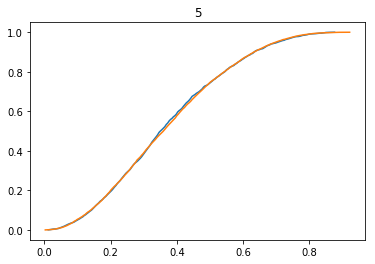

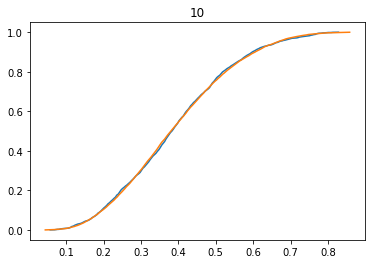

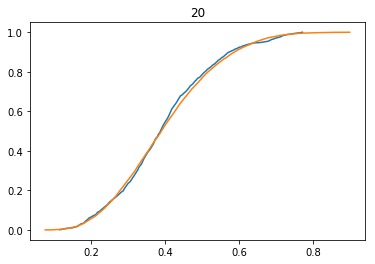

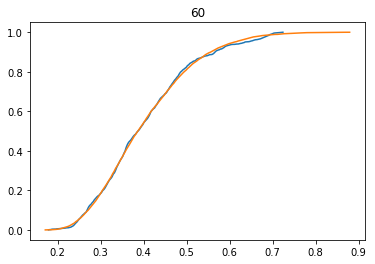

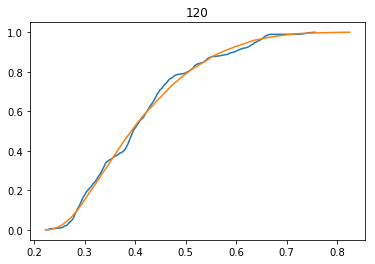

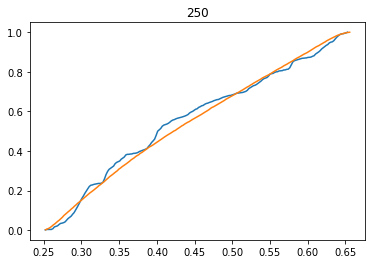

In [9]:
for i in [5,10,20,60,120,250]:
    a,b,loc,scale = stats.johnsonsb.fit(full_corr[i].dropna())
    num_bins = 200
    counts, bin_edges = np.histogram(full_corr[i].dropna(), bins=num_bins)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf/cdf[-1])
    counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=10000), bins=num_bins)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf/cdf[-1])
    plt.title(i)
    plt.show()

20160115
0.039977478278105216 0.11539602107256818


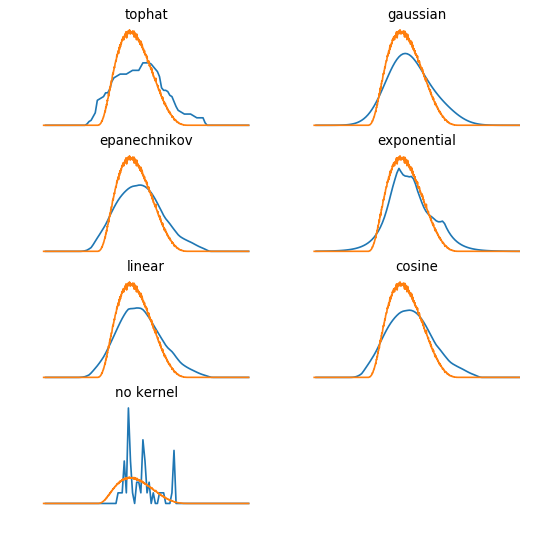

In [10]:
point = 1699
duration = 50
confident_level = 0.05
n_day = 10

print(full_corr[n_day].index.tolist()[point])

X = np.array(full_corr[n_day].iloc[point-duration:point])[:, np.newaxis]
X_plot = np.linspace(-.5, 1.5, 100)[:, np.newaxis]
a,b,loc,scale = stats.johnsonsb.fit(full_corr[n_day])
counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=1000000),\
                                 bins=np.linspace(-.5,1.5,1000), density = True)
theoretical_lower_location =  bin_edges[1:][sum(1-(np.cumsum(np.diff(bin_edges)*counts)>confident_level))-1]
theoretical_upper_location =  bin_edges[1:][sum(1-(np.cumsum(np.diff(bin_edges)*counts)>(1-confident_level)))]

plt.figure(figsize=(8,8),dpi=80)

plt.subplot(421)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='tophat',),grid_param)
kde = kde_grid.fit(X).best_estimator_
#print(kde_grid.best_params_)
log_dens = kde.score_samples(X_plot[1:])
kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<theoretical_lower_location]) - confident_level
kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>theoretical_upper_location]) - confident_level
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('tophat')
plt.axis('off')

plt.subplot(422)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='gaussian',),grid_param)
kde = kde_grid.fit(X).best_estimator_
#print(kde_grid.best_params_)
log_dens = kde.score_samples(X_plot[1:])
kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<theoretical_lower_location]) - confident_level
kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>theoretical_upper_location]) - confident_level
print(kernel_lower_percentage_diff,kernel_upper_percentage_diff)
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('gaussian')
plt.axis('off')

plt.subplot(423)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='epanechnikov',),grid_param)
kde = kde_grid.fit(X).best_estimator_
#print(kde_grid.best_params_)
log_dens = kde.score_samples(X_plot[1:])
kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<theoretical_lower_location]) - confident_level
kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>theoretical_upper_location]) - confident_level
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('epanechnikov')
plt.axis('off')

plt.subplot(424)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='exponential',),grid_param)
kde = kde_grid.fit(X).best_estimator_
#print(kde_grid.best_params_)
log_dens = kde.score_samples(X_plot[1:])
kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<theoretical_lower_location]) - confident_level
kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>theoretical_upper_location]) - confident_level
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('exponential')
plt.axis('off')

plt.subplot(425)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='linear',),grid_param)
kde = kde_grid.fit(X).best_estimator_
#print(kde_grid.best_params_)
log_dens = kde.score_samples(X_plot[1:])
kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<theoretical_lower_location]) - confident_level
kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>theoretical_upper_location]) - confident_level
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('linear')
plt.axis('off')

plt.subplot(426)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='cosine',),grid_param)
kde = kde_grid.fit(X).best_estimator_
#print(kde_grid.best_params_)
log_dens = kde.score_samples(X_plot[1:])
kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<theoretical_lower_location]) - confident_level
kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>theoretical_upper_location]) - confident_level
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('cosine')
plt.axis('off')

plt.subplot(4,2,7)
plt.plot(X_plot[:, 0][1:], np.histogram(X, bins=X_plot[:, 0], density = True)[0])
plt.plot(bin_edges[1:], counts)
plt.title('no kernel')
plt.axis('off')
plt.show()

In [31]:
X = np.random.normal(size=40)[:,np.newaxis]

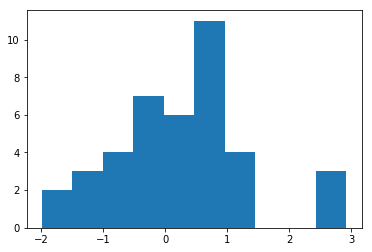

In [32]:
plt.hist(X,bins=10)
plt.show()

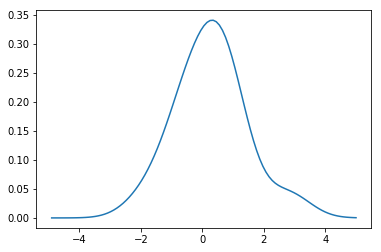

In [36]:
X_plot = np.linspace(-5, 5, 100)[:, np.newaxis]
grid_param = {
    'bandwidth':np.linspace(0.7,0.7,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='gaussian',),grid_param)
kde = kde_grid.fit(X).best_estimator_
log_dens = kde.score_samples(X_plot[1:])
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.show()

In [11]:
def kde_fitting_lower_tail(series,tll,tul,duration = 50, confident_level = 0.05, kernel_function = 'gaussian'):
    #available kernel functions:
    #gaussian  tophat  epanechnikov  cosine  linear  exponential
    if len(series) < duration:
        return np.nan
    if kernel_function not in ['gaussian','tophat','epanechnikov','cosine','linear','exponential']:
        return np.nan
    
    X = np.array(series)[:, np.newaxis]
    X_plot = np.linspace(-.5, 1.5, 100)[:, np.newaxis]

    grid_param = {
        'bandwidth':np.linspace(0.01,0.5,100)
    }
    kde_grid = GridSearchCV(KernelDensity(kernel=kernel_function,),grid_param)
    kde = kde_grid.fit(X).best_estimator_
    log_dens = kde.score_samples(X_plot[1:])
    kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<tll]) - confident_level
    kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>tul]) - confident_level
    
    return kernel_lower_percentage_diff

In [12]:
def kde_fitting_upper_tail(series,tll,tul,duration = 50, confident_level = 0.05, kernel_function = 'gaussian'):
    #available kernel functions:
    #gaussian  tophat  epanechnikov  cosine  linear  exponential
    if len(series) < duration:
        return np.nan
    if kernel_function not in ['gaussian','tophat','epanechnikov','cosine','linear','exponential']:
        return np.nan
    
    X = np.array(series)[:, np.newaxis]
    X_plot = np.linspace(-.5, 1.5, 100)[:, np.newaxis]

    grid_param = {
        'bandwidth':np.linspace(0.01,0.5,100)
    }
    kde_grid = GridSearchCV(KernelDensity(kernel=kernel_function,),grid_param)
    kde = kde_grid.fit(X).best_estimator_
    log_dens = kde.score_samples(X_plot[1:])
    kernel_lower_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]<tll]) - confident_level
    kernel_upper_percentage_diff = np.sum((np.diff(X_plot[:, 0])*np.exp(log_dens))[X_plot[:, 0][1:]>tul]) - confident_level
    
    return kernel_upper_percentage_diff

full_kde = {}
for part in ['lower','upper']:
    if part not in full_kde.keys():
        full_kde[part] = {}
    for confident_level in [0.025,0.05,0.1]:
        if confident_level not in full_kde[part].keys():
            full_kde[part][confident_level] = {}
        for n_day in [5,10,20,60]:
            if n_day not in full_kde[part][confident_level].keys():
                full_kde[part][confident_level][n_day] = {}
            a,b,loc,scale = stats.johnsonsb.fit(full_corr[n_day])
            counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=1000000),\
                                                bins=np.linspace(-.5,1.5,1000), density = True)
            theoretical_lower_location =  bin_edges[1:][sum(1-(np.cumsum(np.diff(bin_edges)*counts)>confident_level))-1]
            theoretical_upper_location =  bin_edges[1:][sum(1-(np.cumsum(np.diff(bin_edges)*counts)>(1-confident_level)))]
            for duration in [10,20,60,120]:
                if part == 'lower':
                    full_kde[part][confident_level][n_day][duration] = full_corr[n_day].rolling(window=duration).apply(kde_fitting_lower_tail,\
                                                        args=(theoretical_lower_location,theoretical_upper_location,\
                                                              duration,confident_level,'gaussian',))
                else:
                    full_kde[part][confident_level][n_day][duration] = full_corr[n_day].rolling(window=duration).apply(kde_fitting_upper_tail,\
                                                        args=(theoretical_lower_location,theoretical_upper_location,\
                                                              duration,confident_level,'gaussian',))
                print(part,n_day,confident_level,duration)
                with open('full_kde.pkl', 'wb') as handle:
                    pickle.dump(full_kde, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('full_kde.pkl', 'rb') as handle:
    data = pickle.load(handle)

full_kde_df = pd.DataFrame()
for key_1 in data.keys():
    for key_2 in data[key_1].keys():
        for key_3 in data[key_1][key_2].keys():
            for key_4 in data[key_1][key_2][key_3].keys():
                info = data[key_1][key_2][key_3][key_4].copy()
                info.name = str(key_1) + '_' + str(key_2) + '_' + str(key_3) + '_' + str(key_4)
                full_kde_df = pd.concat([full_kde_df,info],axis=1)

In [16]:
full_kde_df = pd.read_csv('full_kde.csv', index_col = 0)

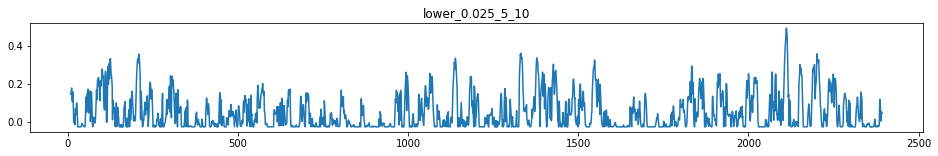

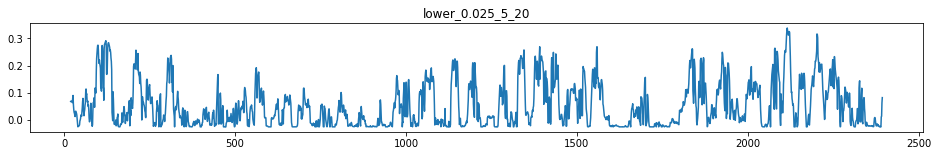

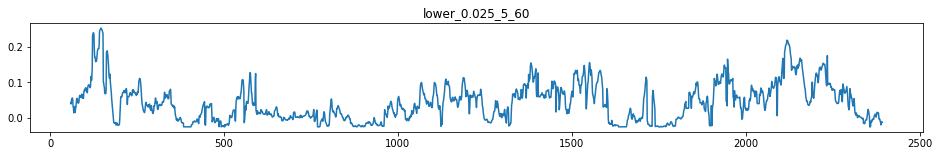

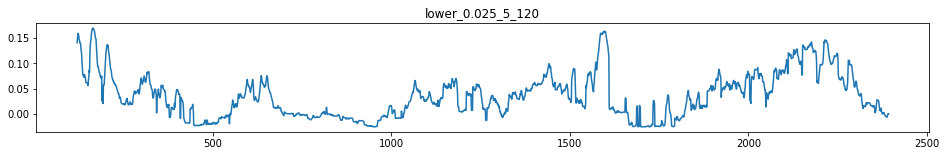

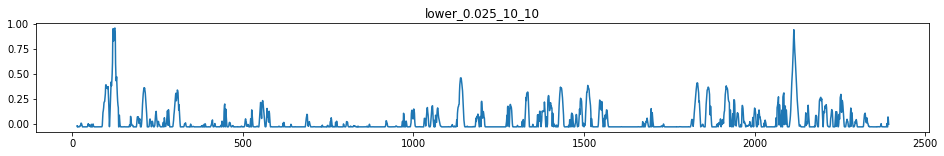

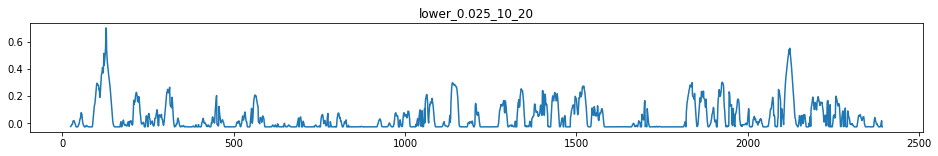

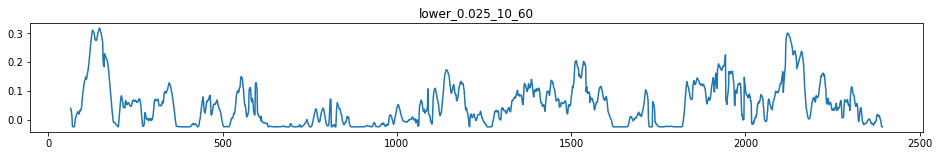

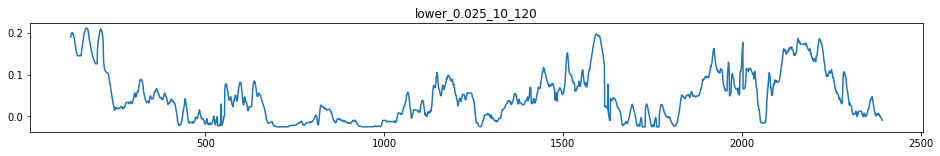

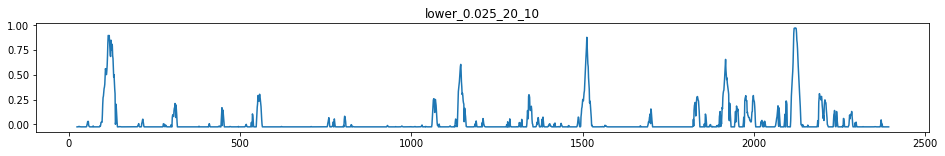

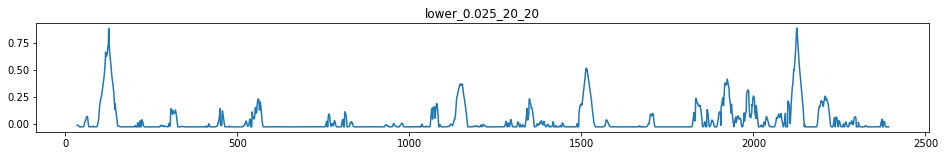

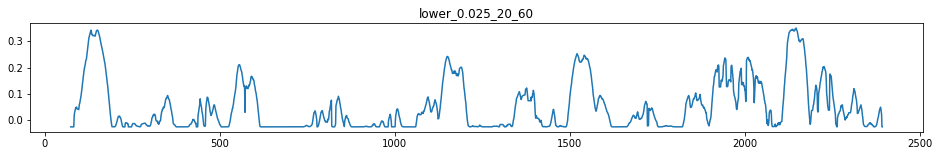

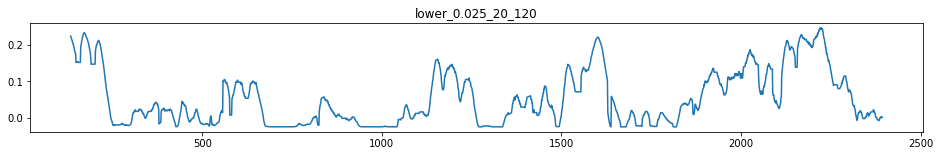

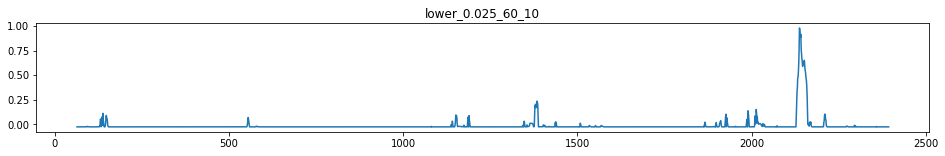

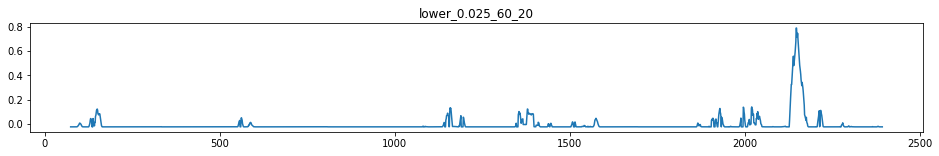

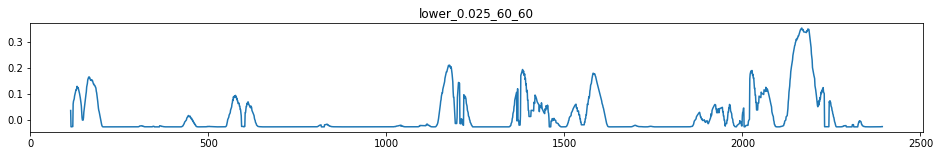

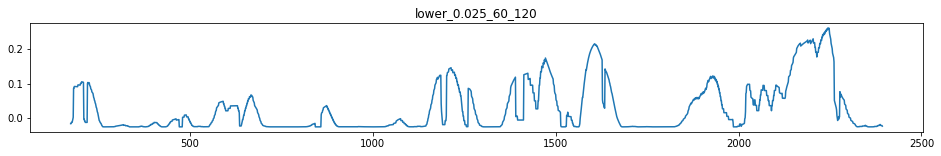

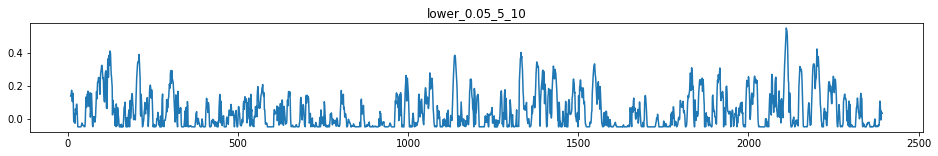

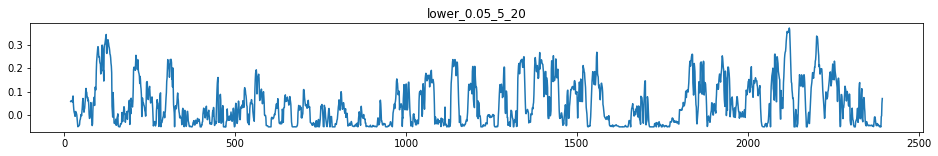

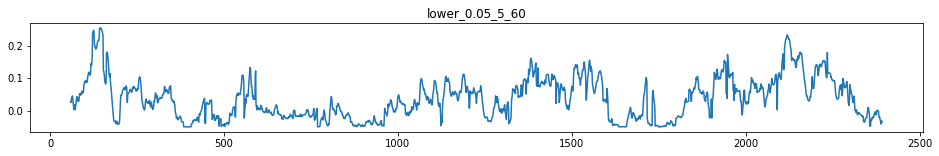

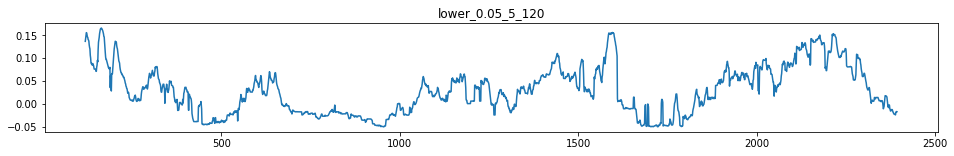

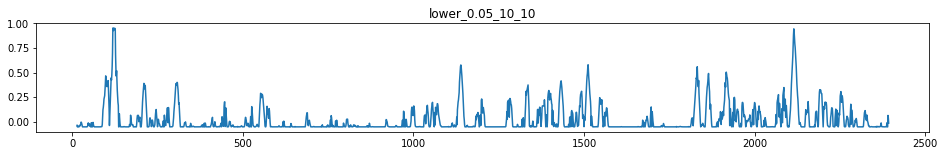

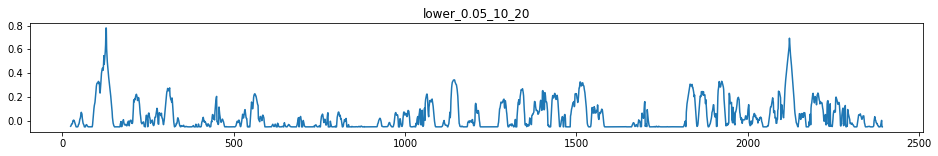

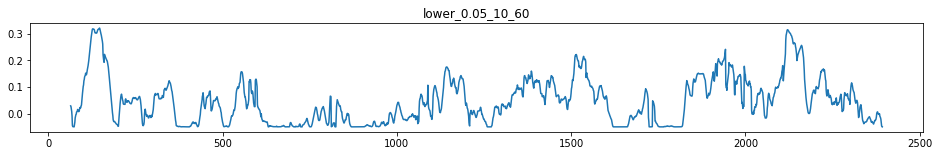

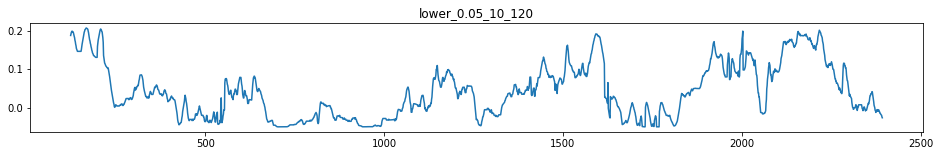

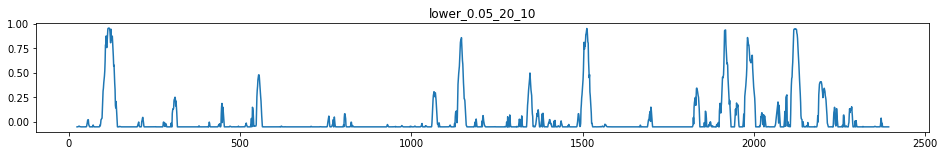

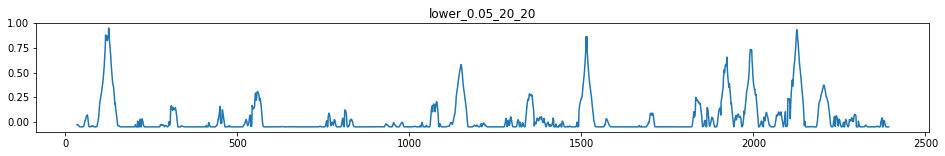

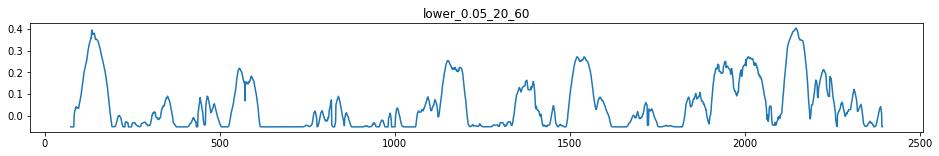

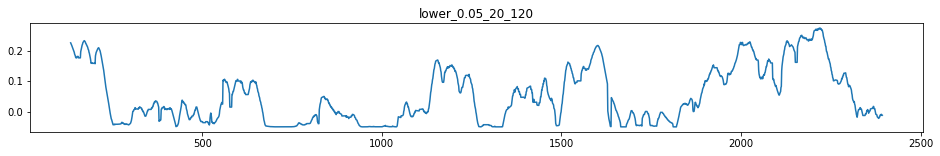

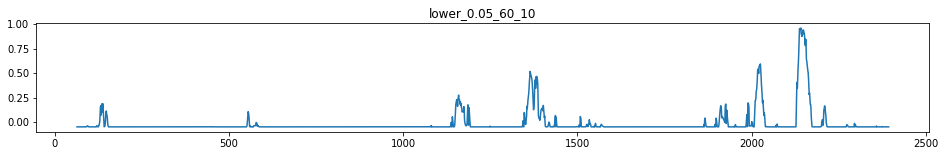

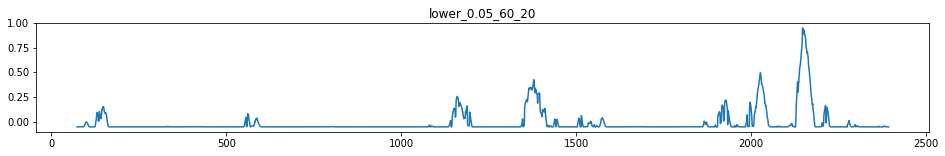

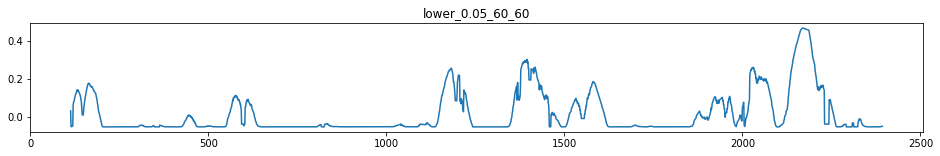

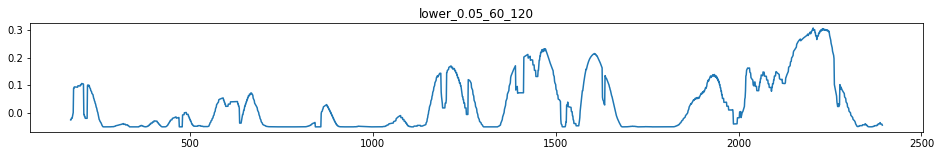

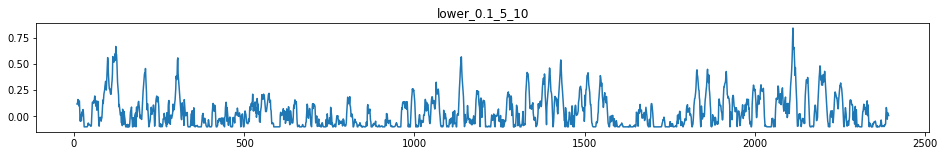

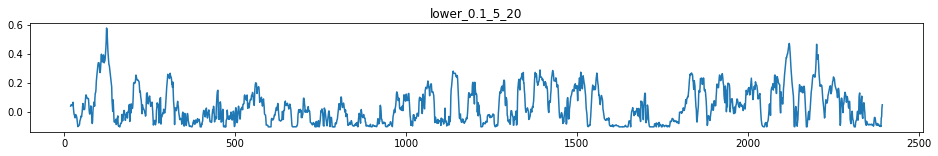

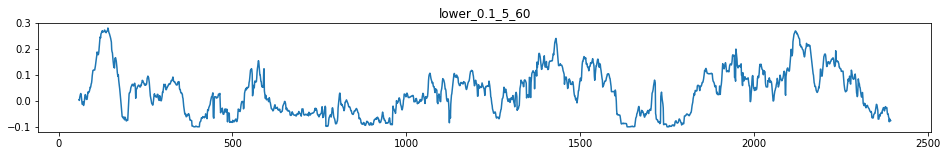

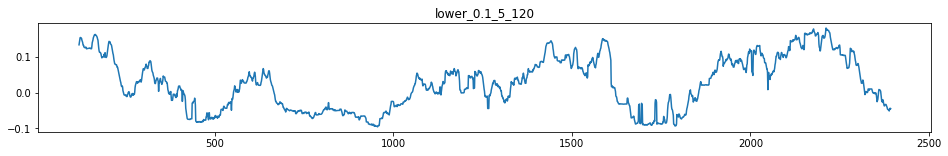

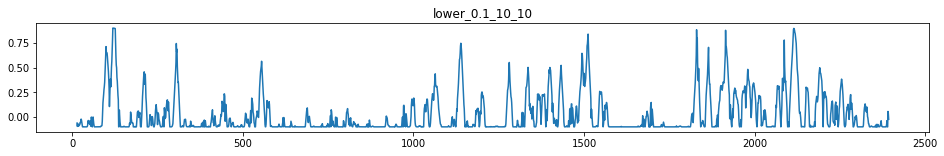

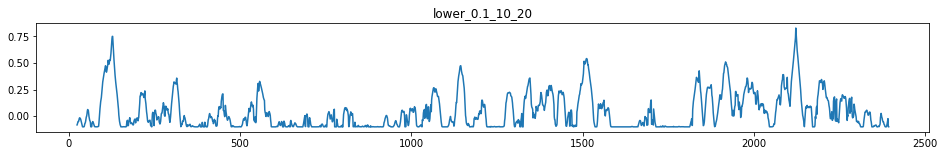

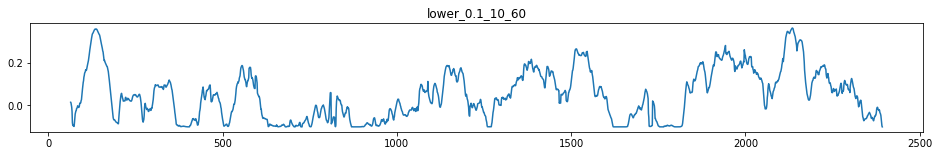

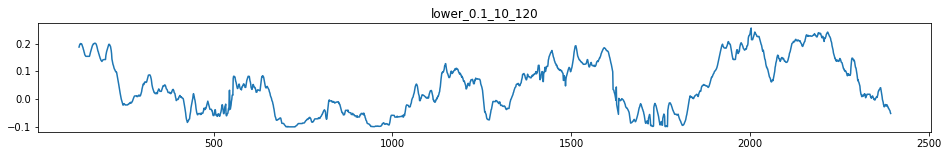

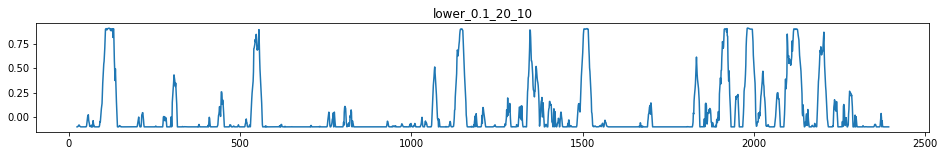

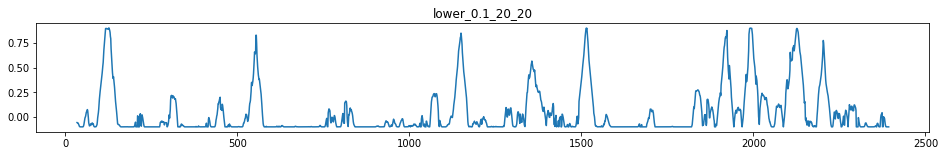

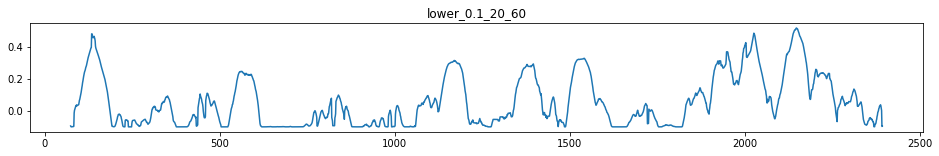

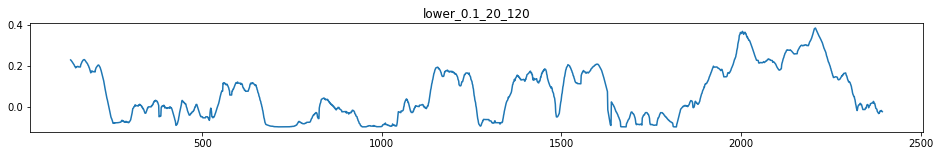

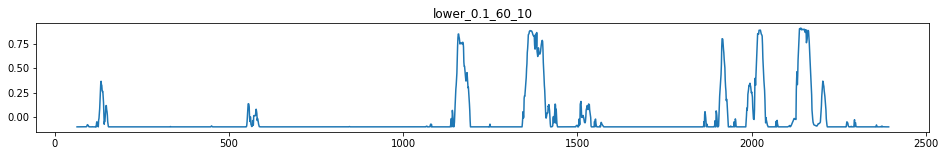

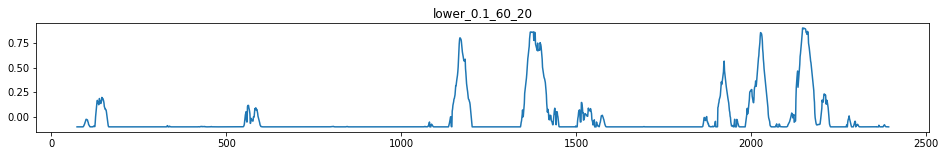

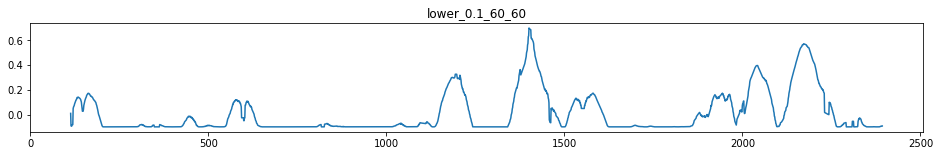

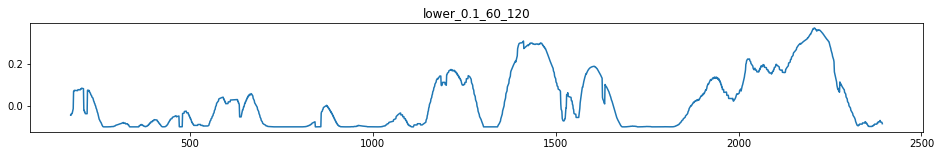

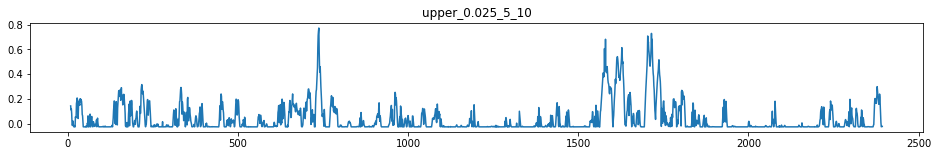

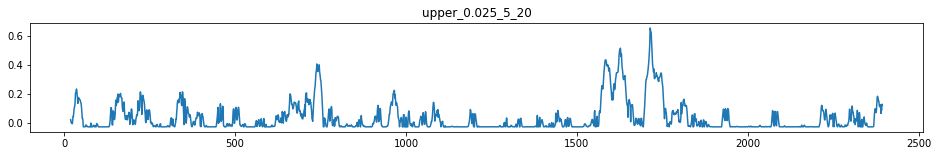

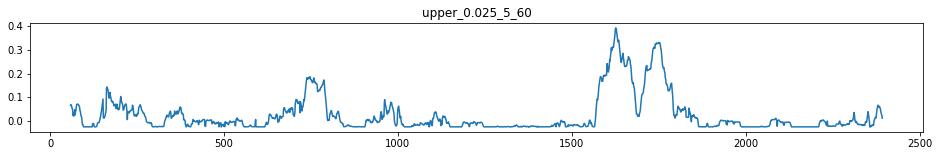

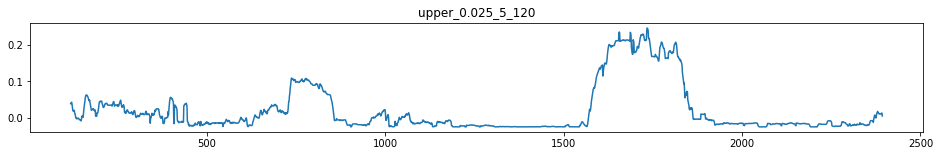

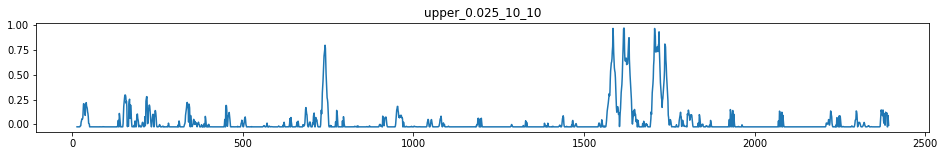

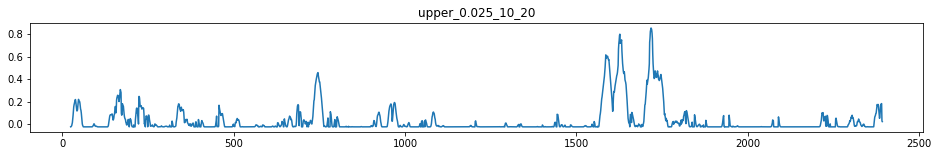

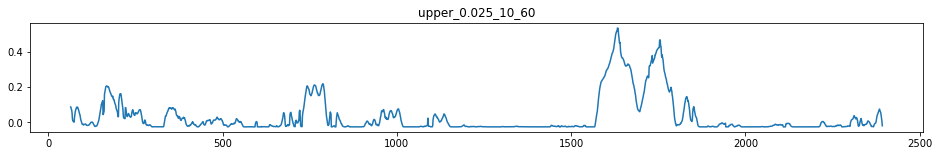

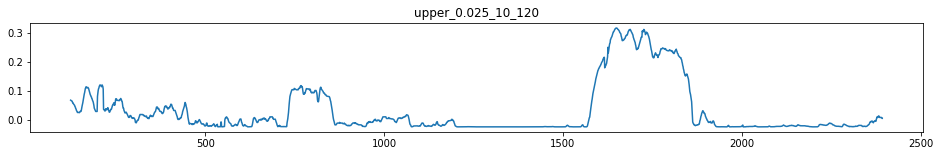

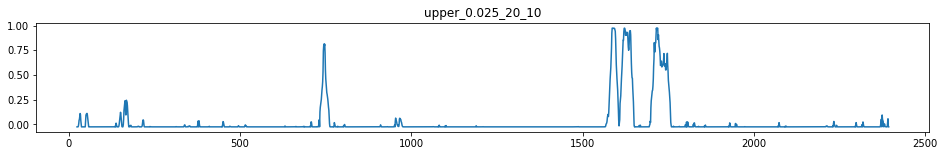

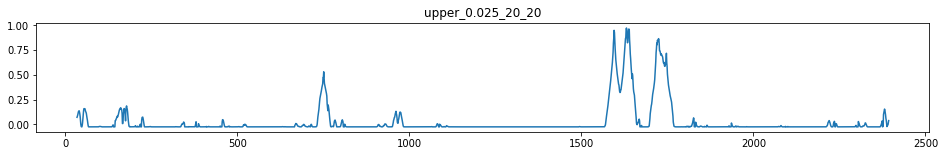

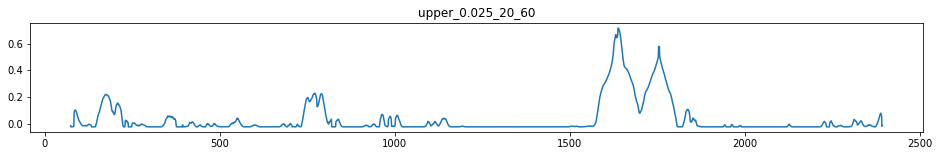

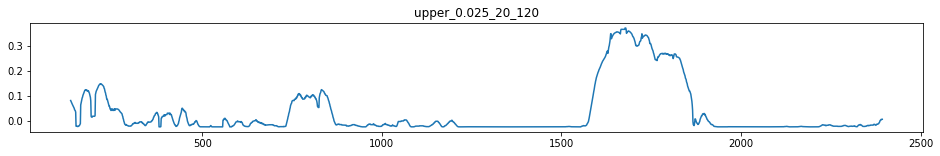

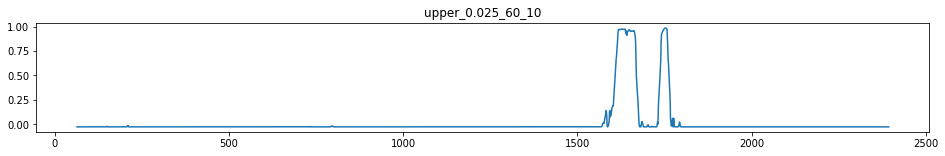

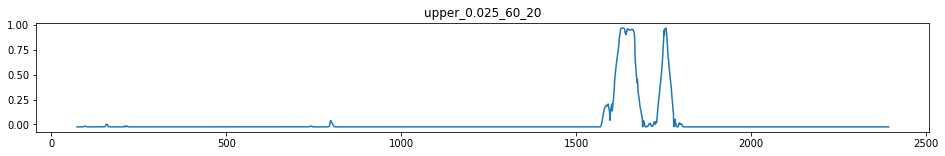

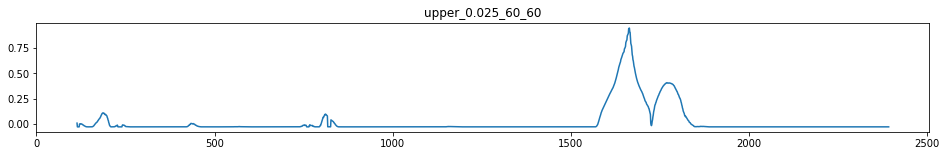

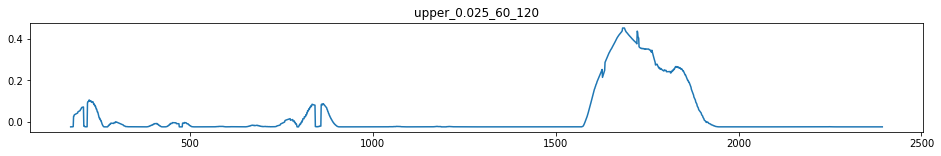

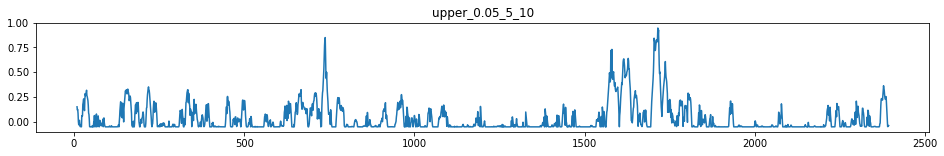

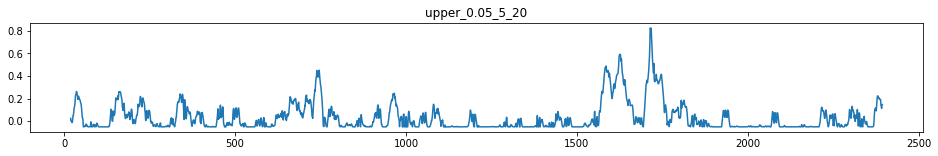

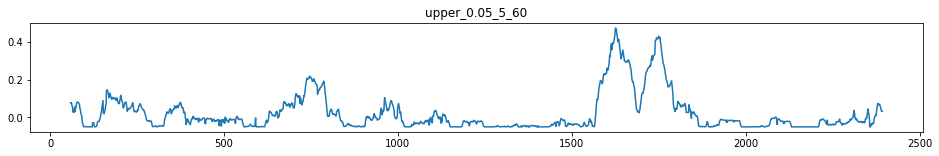

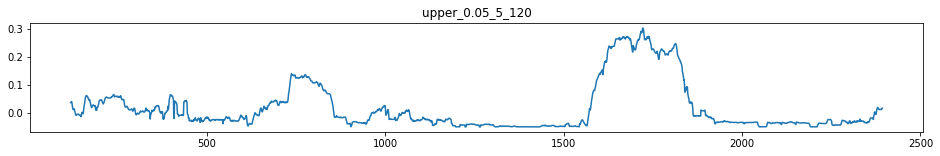

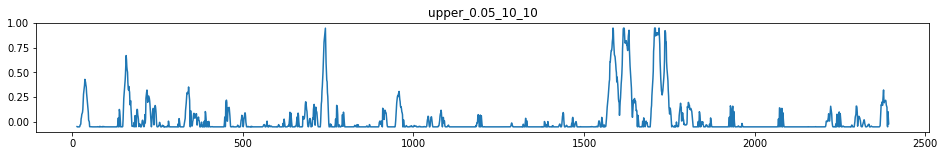

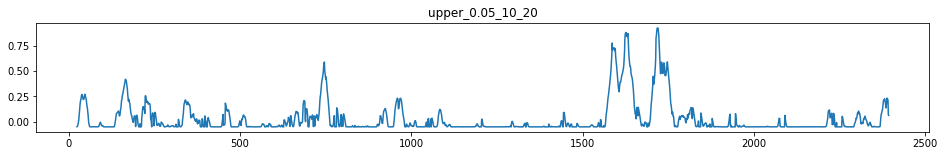

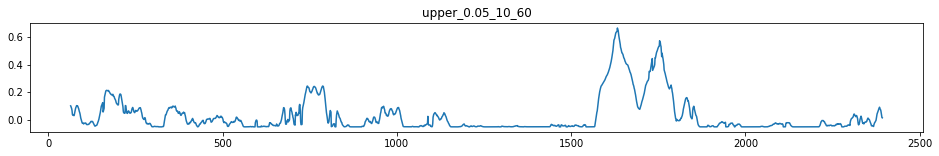

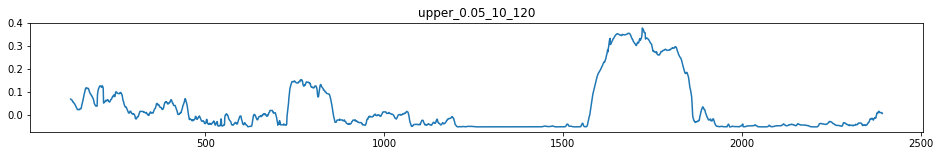

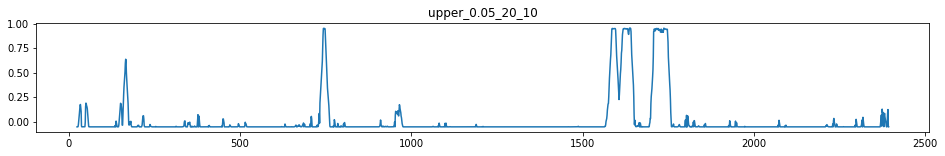

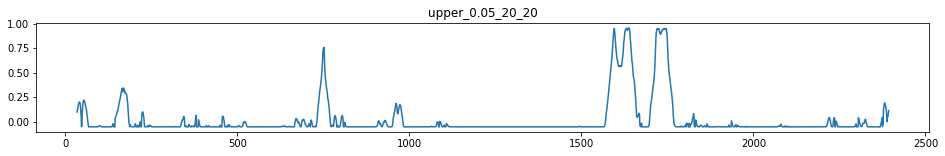

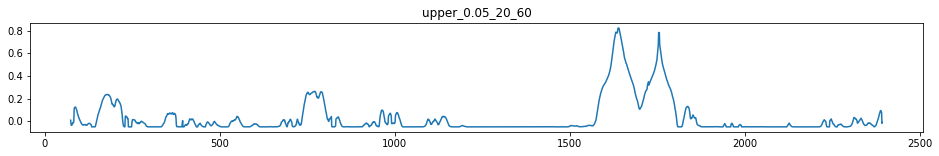

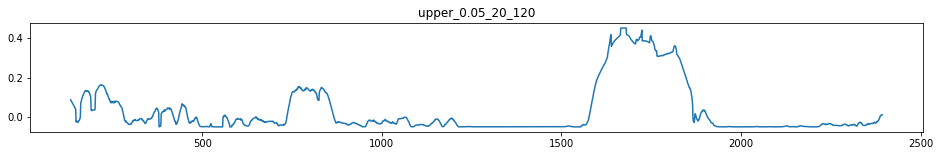

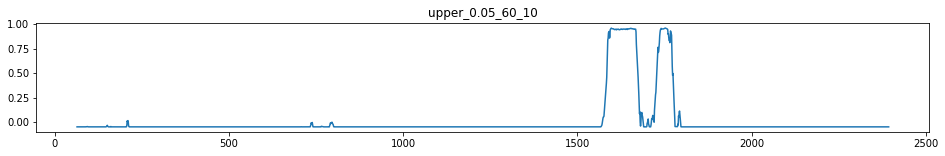

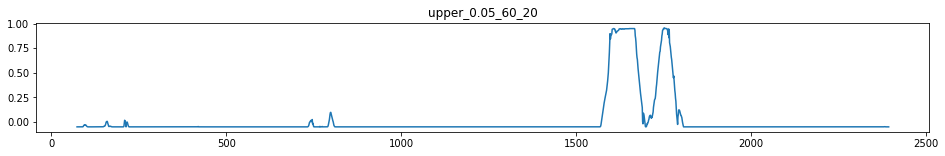

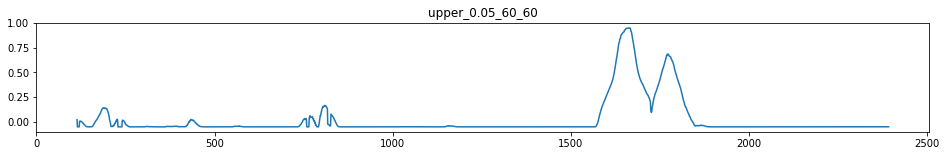

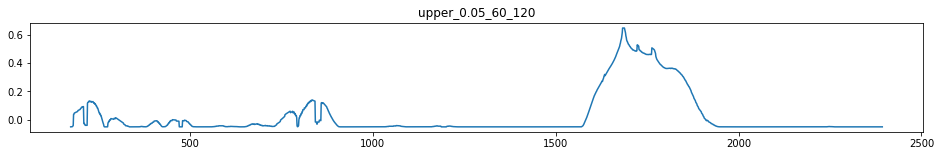

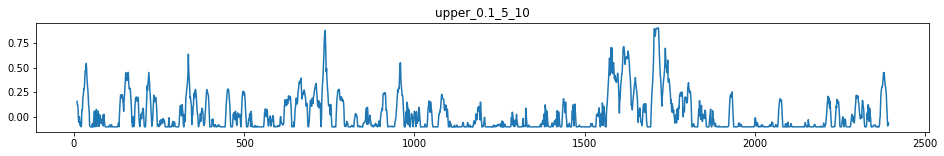

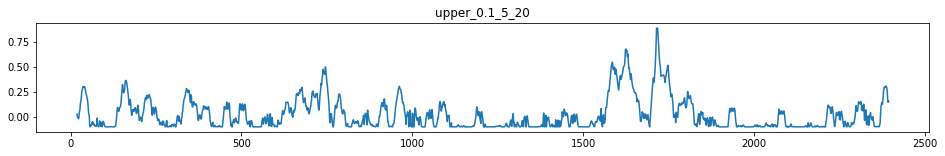

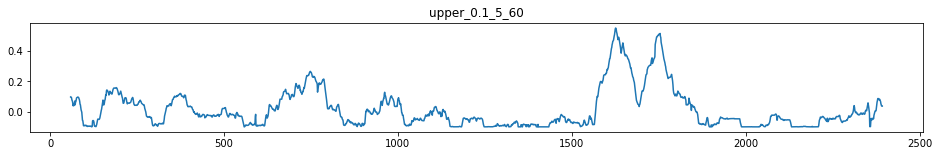

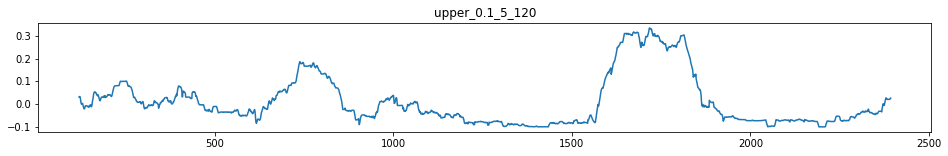

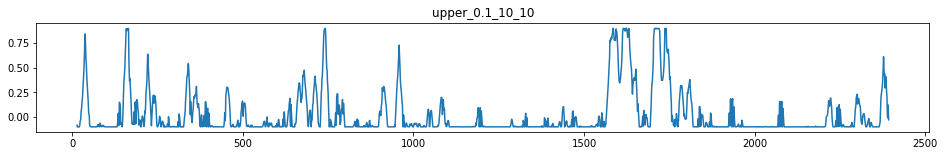

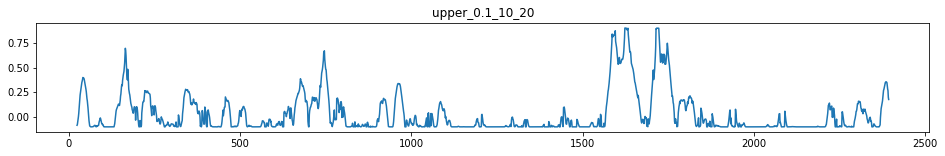

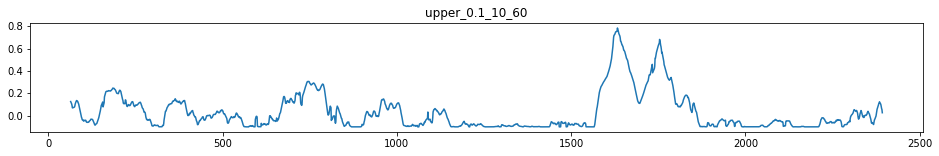

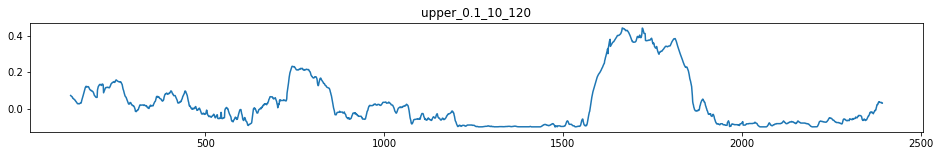

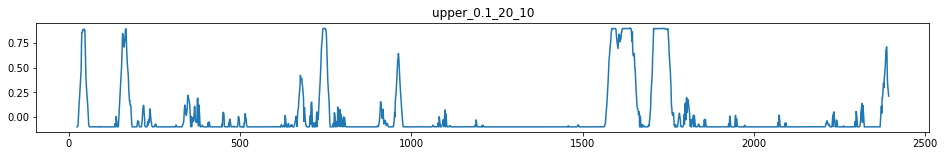

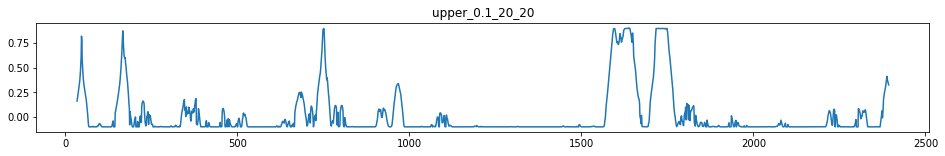

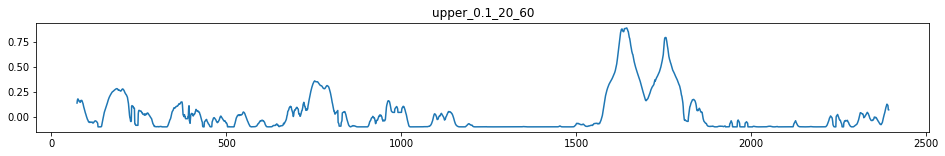

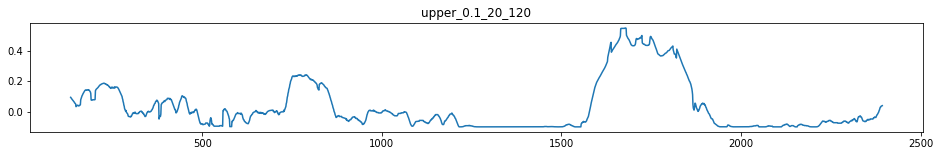

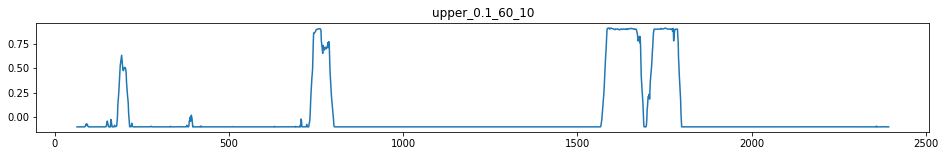

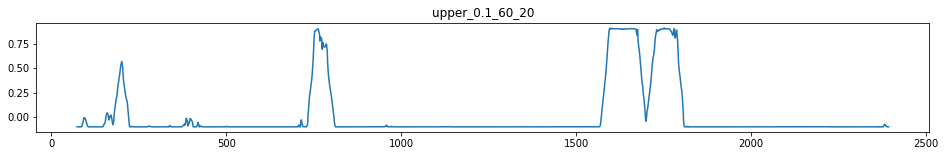

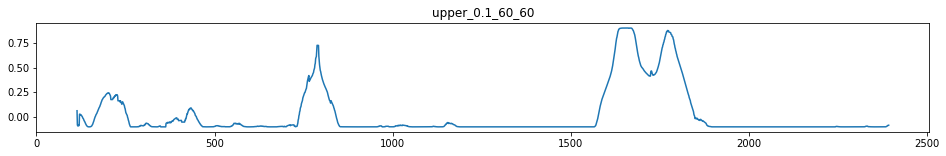

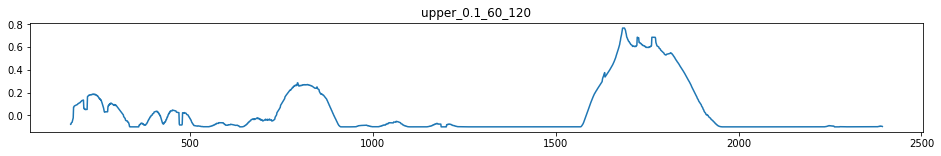

In [17]:
for item in list(full_kde_df):
    plt.figure(figsize = (16,2))
    plt.plot(full_kde_df[item].tolist())
    plt.title(item)
    plt.show()

In [18]:
for i in full_cc_for_remove.index:
    if i not in full_kde_df.index and i > 20180101:
        full_kde_df.loc[i] = np.nan

In [38]:
for part in ['lower','upper']:
    for confident_level in [0.025,0.05,0.1]:
        for n_day in [5,10,20,60]:
            a,b,loc,scale = stats.johnsonsb.fit(full_corr[n_day])
            counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=1000000),\
                                                bins=np.linspace(-.5,1.5,1000), density = True)
            theoretical_lower_location =  bin_edges[1:][sum(1-(np.cumsum(np.diff(bin_edges)*counts)>confident_level))-1]
            theoretical_upper_location =  bin_edges[1:][sum(1-(np.cumsum(np.diff(bin_edges)*counts)>(1-confident_level)))]
            for duration in [10,20,60,120]:
                title = part + '_' + str(confident_level) + '_' + str(n_day) + '_' + str(duration)
                for update in full_kde_df.index.tolist()[-20:]:
                    if pd.isnull(full_kde_df.loc[update,title]):
                        if part == 'lower':
                            full_kde_df.loc[update,title] = \
                                kde_fitting_lower_tail(full_corr[n_day][full_corr[n_day].index<=update].iloc[-duration:],\
                                                       theoretical_lower_location,theoretical_upper_location,\
                                                       duration = duration, confident_level = confident_level, kernel_function = 'gaussian')
                        elif part == 'upper':
                            full_kde_df.loc[update,title] = \
                                kde_fitting_upper_tail(full_corr[n_day][full_corr[n_day].index<=update].iloc[-duration:],\
                                                       theoretical_lower_location,theoretical_upper_location,\
                                                       duration = duration, confident_level = confident_level, kernel_function = 'gaussian')
                print(part,n_day,confident_level,duration)

lower 5 0.025 10
lower 5 0.025 20
lower 5 0.025 60
lower 5 0.025 120
lower 10 0.025 10
lower 10 0.025 20
lower 10 0.025 60
lower 10 0.025 120
lower 20 0.025 10
lower 20 0.025 20
lower 20 0.025 60
lower 20 0.025 120
lower 60 0.025 10
lower 60 0.025 20
lower 60 0.025 60
lower 60 0.025 120
lower 5 0.05 10
lower 5 0.05 20
lower 5 0.05 60
lower 5 0.05 120
lower 10 0.05 10
lower 10 0.05 20
lower 10 0.05 60
lower 10 0.05 120
lower 20 0.05 10
lower 20 0.05 20
lower 20 0.05 60
lower 20 0.05 120
lower 60 0.05 10
lower 60 0.05 20
lower 60 0.05 60
lower 60 0.05 120
lower 5 0.1 10
lower 5 0.1 20
lower 5 0.1 60
lower 5 0.1 120
lower 10 0.1 10
lower 10 0.1 20
lower 10 0.1 60
lower 10 0.1 120
lower 20 0.1 10
lower 20 0.1 20
lower 20 0.1 60
lower 20 0.1 120
lower 60 0.1 10
lower 60 0.1 20
lower 60 0.1 60
lower 60 0.1 120
upper 5 0.025 10
upper 5 0.025 20
upper 5 0.025 60
upper 5 0.025 120
upper 10 0.025 10
upper 10 0.025 20
upper 10 0.025 60
upper 10 0.025 120
upper 20 0.025 10
upper 20 0.025 20
upper 

In [39]:
full_kde_df

lower_0.025_5_10  lower_0.025_5_20  lower_0.025_5_60  \
0                                                                
20090112               NaN               NaN               NaN   
20090113               NaN               NaN               NaN   
20090114               NaN               NaN               NaN   
20090115               NaN               NaN               NaN   
20090116               NaN               NaN               NaN   
20090119               NaN               NaN               NaN   
20090120               NaN               NaN               NaN   
20090121               NaN               NaN               NaN   
20090122               NaN               NaN               NaN   
20090123          0.147834               NaN               NaN   
20090202          0.145959               NaN               NaN   
20090203          0.168609               NaN               NaN   
20090204          0.179191               NaN               NaN   
20090205          0.130418               NaN               NaN   
20090206          0.107358               NaN               NaN   
20090209          0.149012               NaN               NaN   
20090210          0.158808               NaN               NaN   
20090211          0.067492               NaN               NaN   
20090212          0.000408               NaN               NaN   
20090213         -0.004291          0.068458               NaN   
20090216          0.040586          0.069356               NaN   
20090217         -0.010266          0.069482               NaN   
20090218         -0.013344          0.069486               NaN   
20090219          0.070273          0.066787               NaN   
20090220          0.053823          0.064123               NaN   
20090223          0.039405          0.080645               NaN   
20090224          0.098199          0.090381               NaN   
20090225          0.100697          0.057923               NaN   
20090226          0.064752          0.039964               NaN   
20090227          0.011356          0.029162               NaN   
...                    ...               ...               ...   
20181012         -0.000452          0.006946          0.005030   
20181015          0.015686          0.009376          0.007681   
20181016         -0.007026          0.008346          0.010458   
20181017         -0.024435         -0.003649          0.010457   
20181018         -0.021190         -0.014021          0.010680   
20181019         -0.023351         -0.020420          0.002239   
20181022         -0.023352         -0.021835          0.006278   
20181023         -0.024266         -0.019585          0.010615   
20181024         -0.021057         -0.014156          0.016049   
20181025         -0.022542         -0.015656          0.015302   
20181026         -0.024266         -0.021399          0.014175   
20181029         -0.017907         -0.017914          0.013975   
20181030         -0.019938         -0.020455          0.014524   
20181031         -0.021167         -0.020875          0.002841   
20181101         -0.016666         -0.024067         -0.003376   
20181102          0.073321         -0.024674         -0.001939   
20181105          0.118624         -0.023909         -0.004393   
20181106          0.096441         -0.024828         -0.009662   
20181107          0.050381         -0.023907         -0.011609   
20181108          0.005277         -0.024933         -0.019442   
20181109          0.055145          0.011738         -0.010033   
20181112          0.046670          0.014128         -0.012333   
20181113          0.045591          0.063063         -0.012569   
20181114          0.046117          0.082427         -0.012333   
20181115          0.041858          0.076260         -0.012333   
20181116          0.043600          0.076275         -0.011464   
20181119          0.051481          0.069616         -0.010652   
20181120          0.049324          0.053442      

20150410


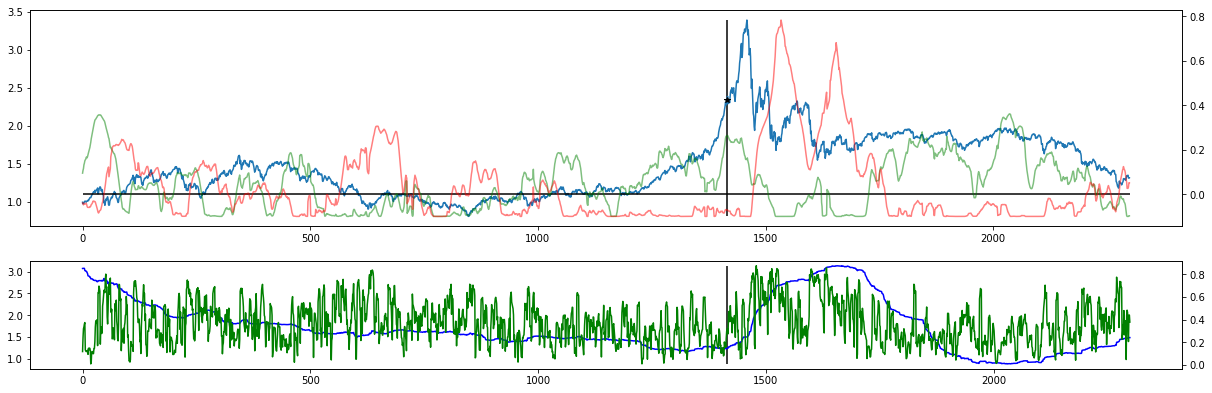

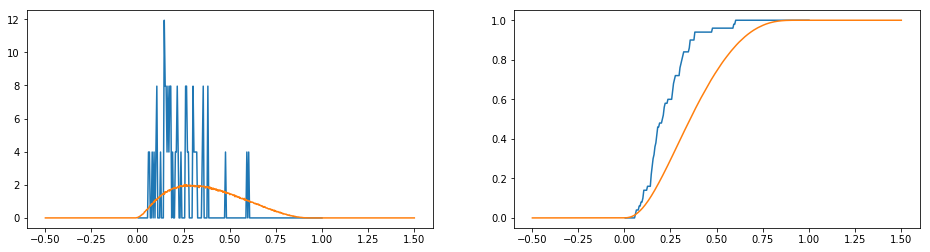

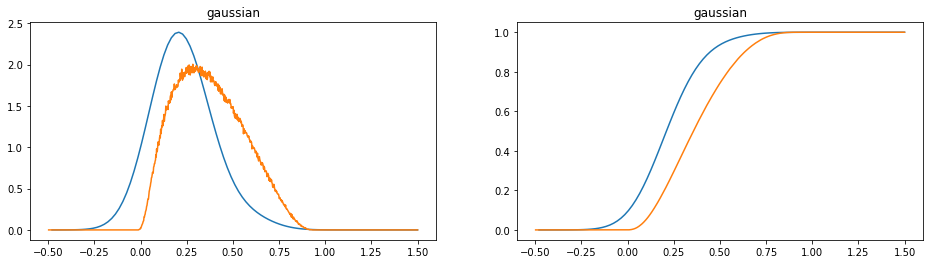

In [21]:
plot_df = pd.concat([zz500,zz500.rolling(window=250).std(),full_corr[5]],axis=1).dropna()
plot_df.columns = ['zz500','std','corr']
plot_df['ret'] = zz500.loc[plot_df.index]
plot_df['corr_ret'] = (plot_df['corr']/plot_df['corr'].shift(1) - 1)*100
plot_df['std_ret'] = (plot_df['std']/plot_df['std'].shift(1) - 1)*100
plot_df['yester_corr_ret'] = plot_df['corr_ret'].shift(1)
plot_df['yester_std_ret'] = plot_df['std_ret'].shift(1)
plot_df['corr_skew'] = full_corr[5].rolling(window=100).apply(calc_skew)
plot_df['kde_lower'] = full_kde_df['lower_0.1_10_60']
plot_df['kde_upper'] = full_kde_df['upper_0.1_10_60']

plot_df.dropna(inplace=True)
plot_df['zz500'] = (plot_df['zz500']/100+1).cumprod()
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_axes([0,0.66,1,0.5])
ax1.plot(plot_df['zz500'].tolist())

point = plot_df.index.tolist().index(next(day_value for day_value in plot_df.index.tolist()[::-1] if day_value <= 20150412))
duration = 50
print(plot_df.index.tolist()[point])
ax1.plot(point,plot_df['zz500'].tolist()[point],c='black',marker='*')

ax2 = fig.add_axes([0,0.33,1,0.25])
ax2.plot(plot_df['std'].tolist(),'b')
ax3 = ax2.twinx()
ax3.plot(plot_df['corr'].tolist(),'g')
#ax4 = fig.add_axes([0,0,1,0.25])
ax4 = ax1.twinx()
ax4.plot(plot_df['kde_lower'].tolist(),'g',alpha=0.5)
ax4.plot(plot_df['kde_upper'].tolist(),'r',alpha=0.5)
#ax5 = ax4.twinx()
#ax5.plot(plot_df['zz500'].tolist(),'b',alpha=0.5)

ax1.vlines(point,np.min(plot_df['zz500'].tolist()),np.max(plot_df['zz500'].tolist()))
ax2.vlines(point,np.min(plot_df['std'].tolist()),np.max(plot_df['std'].tolist()))
#ax5.vlines(point,np.min(plot_df['zz500'].tolist()),np.max(plot_df['zz500'].tolist()))
ax4.hlines(0,0,len(plot_df))
plt.show()

a,b,loc,scale = stats.johnsonsb.fit(plot_df['corr'])
fig = plt.figure(figsize = (16,4))
counts, bin_edges = np.histogram(plot_df['corr'].iloc[point-duration:point], bins=np.linspace(0,1,num_bins), density = True)
cdf = np.cumsum(counts)
ax1 = fig.add_subplot(1,2,1)
ax1.plot(bin_edges[1:], counts)
counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=1000000),\
                                 bins=np.linspace(-.5,1.5,1000), density = True)
cdf = np.cumsum(counts)
ax1.plot(bin_edges[1:], counts)

counts, bin_edges = np.histogram(plot_df['corr'].iloc[point-duration:point], bins=np.linspace(0,1,num_bins), density = True)
cdf = np.cumsum(counts)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(bin_edges[1:], cdf/cdf[-1])
counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=1000000),\
                                 bins=np.linspace(-.5,1.5,1000), density = True)
cdf = np.cumsum(counts)
ax2.plot(bin_edges[1:], cdf/cdf[-1])
plt.show()

X = np.array(plot_df['corr'].iloc[point-duration:point])[:, np.newaxis]
X_plot = np.linspace(-.5, 1.5, 100)[:, np.newaxis]
a,b,loc,scale = stats.johnsonsb.fit(full_corr[5])
counts, bin_edges = np.histogram(stats.johnsonsb.rvs(a, b, loc = loc,scale = scale, size=1000000),\
                                 bins=np.linspace(-.5,1.5,1000), density = True)

plt.figure(figsize=(16,4))

plt.subplot(121)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='gaussian',),grid_param)
kde = kde_grid.fit(X).best_estimator_
log_dens = kde.score_samples(X_plot[1:])
plt.plot(X_plot[:, 0][1:], np.exp(log_dens))
plt.plot(bin_edges[1:], counts)
plt.title('gaussian')

plt.subplot(122)
grid_param = {
    'bandwidth':np.linspace(0.01,0.5,100)
}
kde_grid = GridSearchCV(KernelDensity(kernel='gaussian',),grid_param)
kde = kde_grid.fit(X).best_estimator_
log_dens = kde.score_samples(X_plot[1:])
plt.plot(X_plot[:, 0][1:], np.cumsum(np.exp(log_dens))/np.cumsum(np.exp(log_dens))[-1])
plt.plot(bin_edges[1:], np.cumsum(counts)/np.cumsum(counts)[-1])
plt.title('gaussian')
plt.show()

20150612


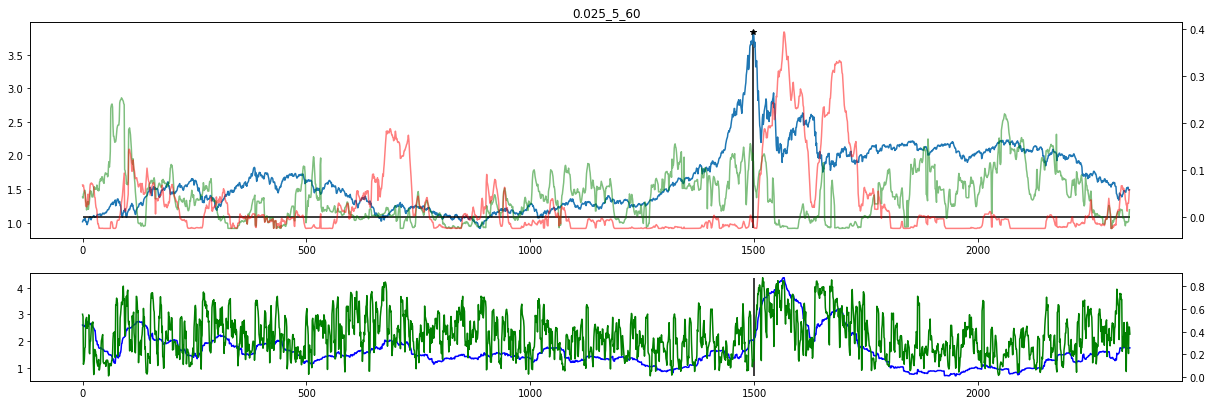

20150612


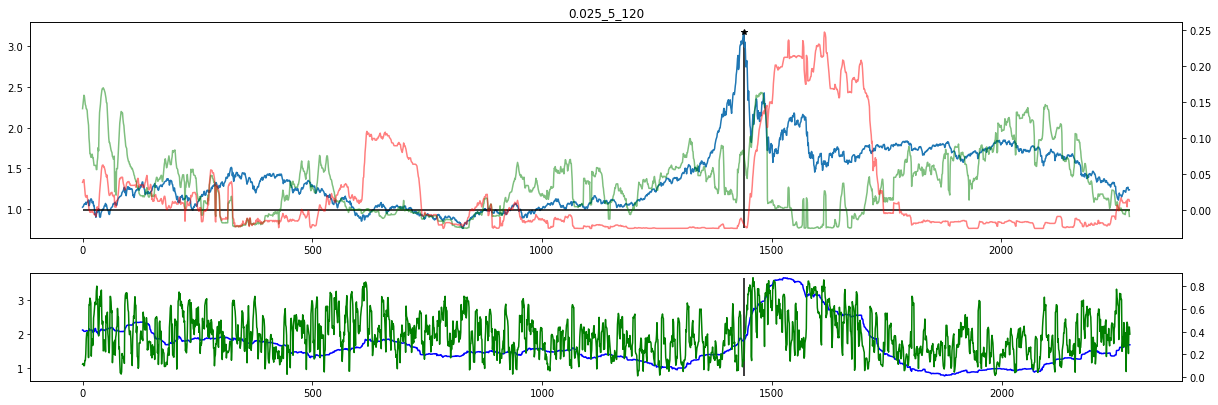

20150612


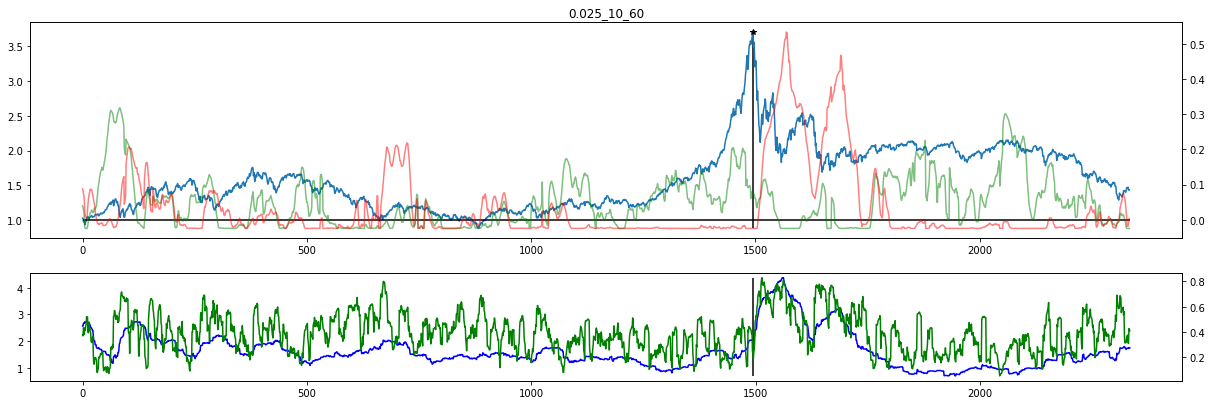

20150612


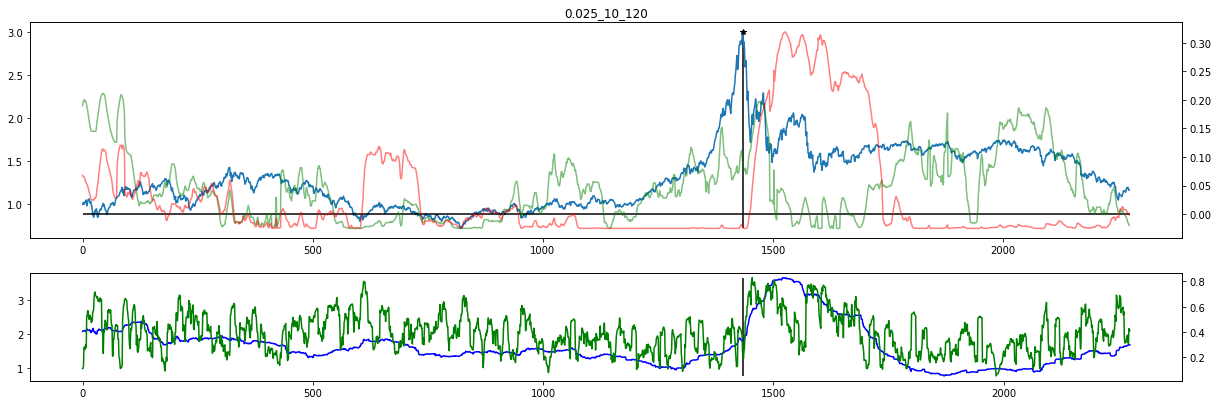

20150612


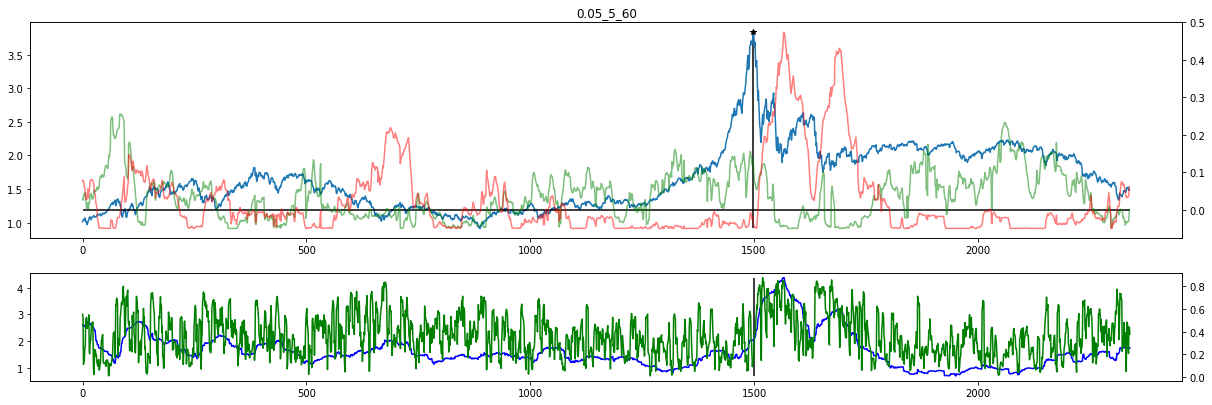

20150612


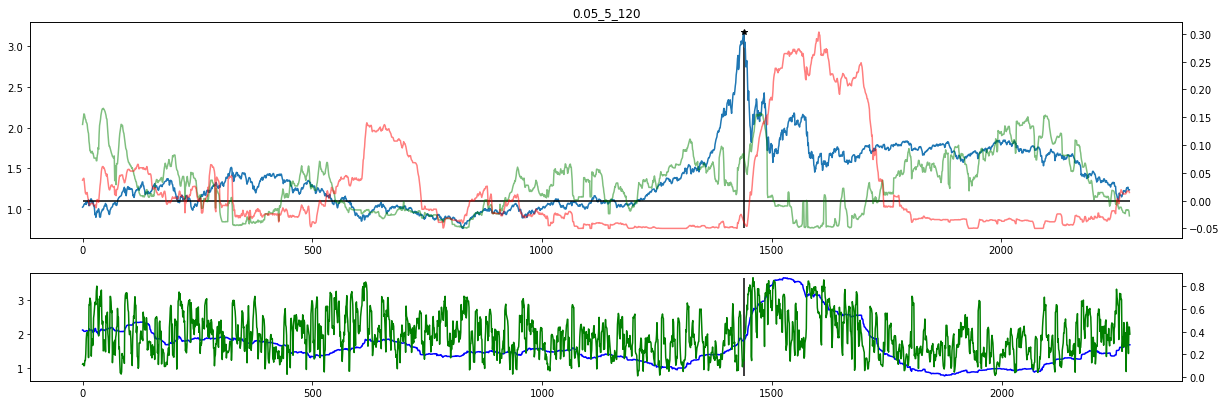

20150612


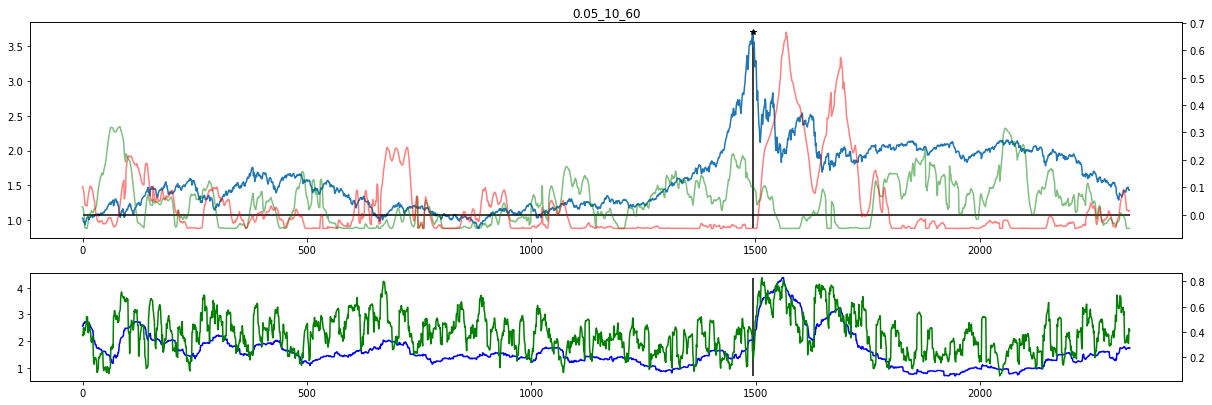

20150612


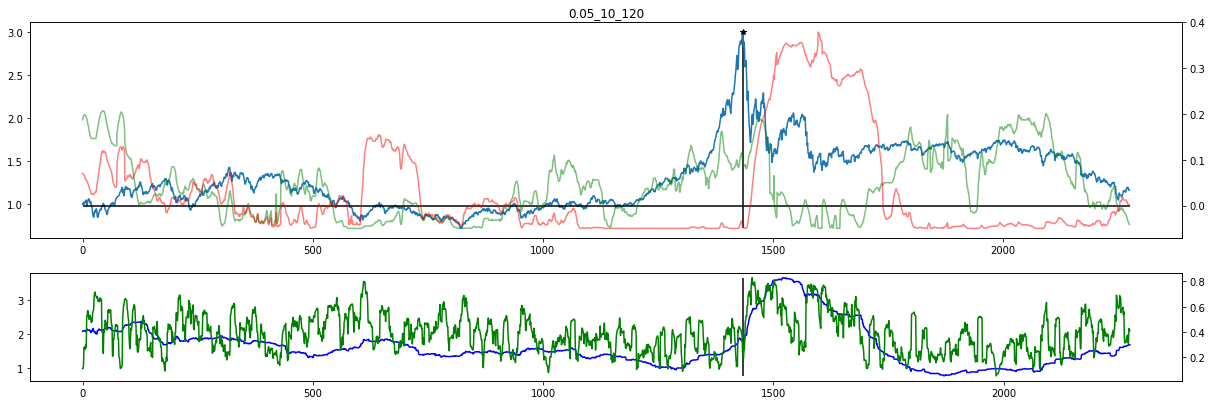

20150612


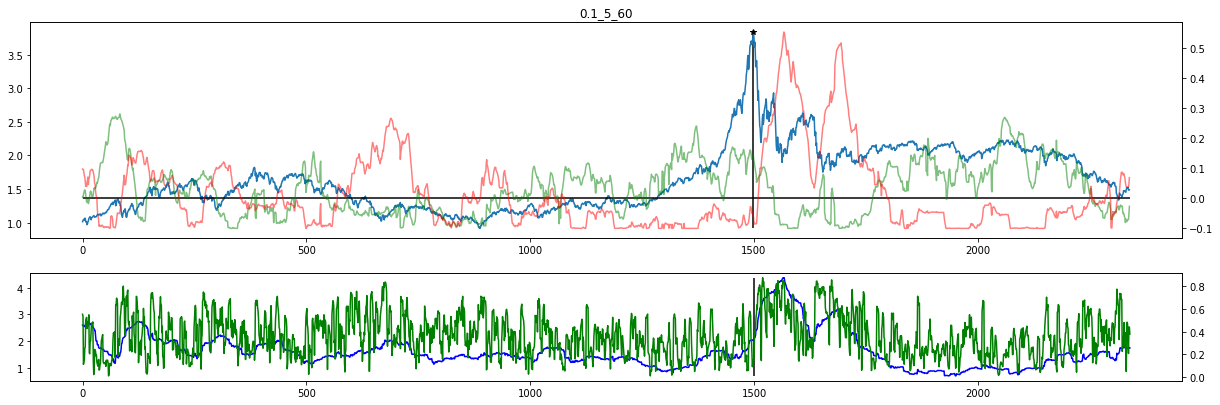

20150612


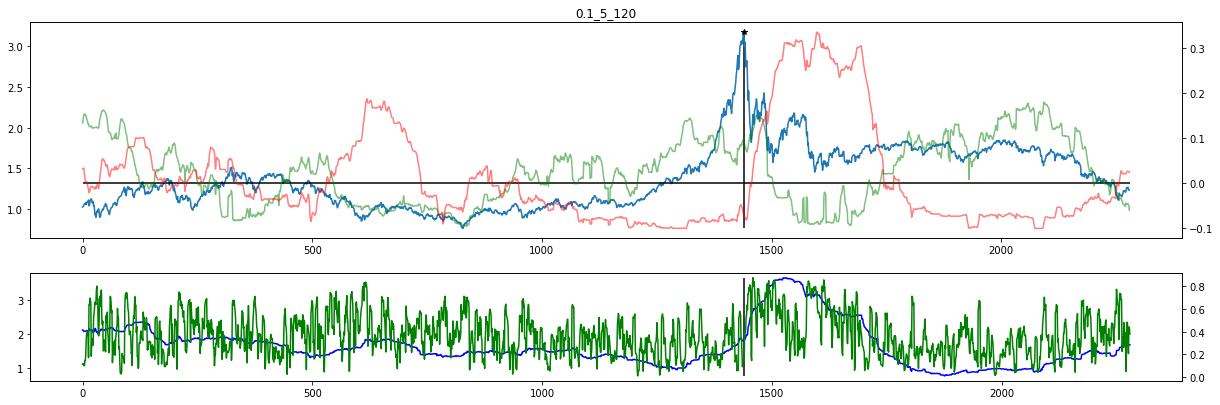

20150612


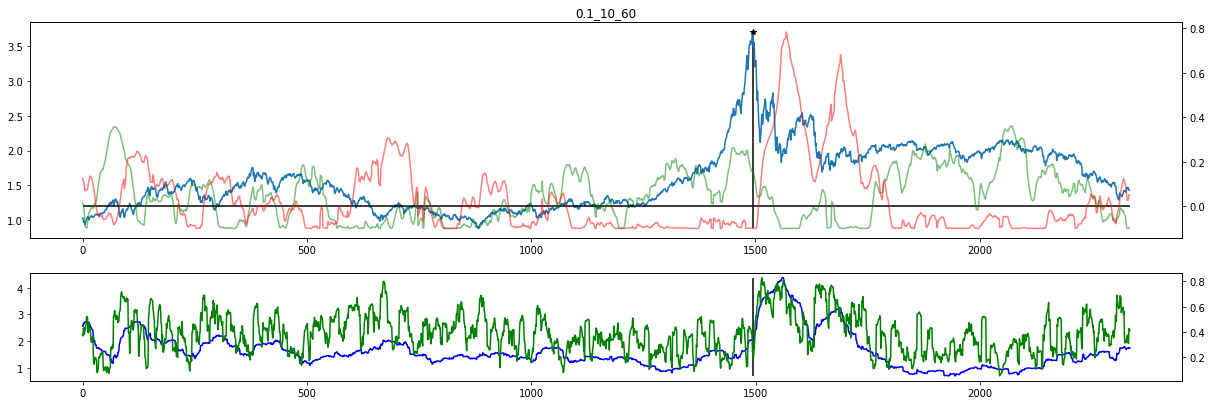

20150612


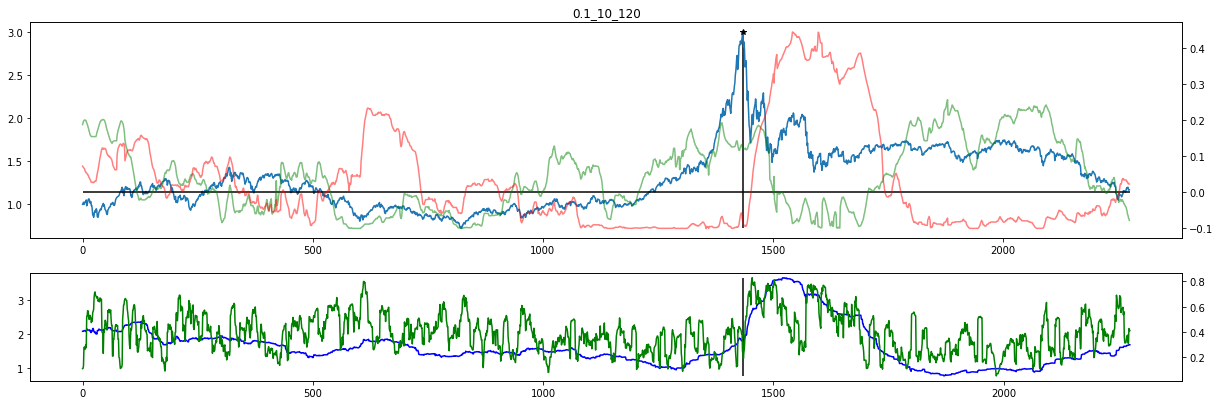

In [22]:
for confident_level in [0.025,0.05,0.1]:
    for n_day in [5,10]:
        for duration in [60,120]:
            plot_df = pd.concat([zz500,zz500.rolling(window=duration).std(),full_corr[n_day]],axis=1).dropna()
            plot_df.columns = ['zz500','std','corr']
            plot_df['ret'] = zz500.loc[plot_df.index]
            plot_df['corr_ret'] = (plot_df['corr']/plot_df['corr'].shift(1) - 1)*100
            plot_df['std_ret'] = (plot_df['std']/plot_df['std'].shift(1) - 1)*100
            plot_df['yester_corr_ret'] = plot_df['corr_ret'].shift(1)
            plot_df['yester_std_ret'] = plot_df['std_ret'].shift(1)
            plot_df['kde_lower'] = full_kde_df['lower_'+str(confident_level)+'_'+str(n_day)+'_'+str(duration)]
            plot_df['kde_upper'] = full_kde_df['upper_'+str(confident_level)+'_'+str(n_day)+'_'+str(duration)]

            plot_df.dropna(inplace=True)
            plot_df['zz500'] = (plot_df['zz500']/100+1).cumprod()
            fig = plt.figure(figsize = (16,6))
            ax1 = fig.add_axes([0,0.66,1,0.5])
            ax1.plot(plot_df['zz500'].tolist())

            point = plot_df.index.tolist().index(20150612)
            print(plot_df.index.tolist()[point])
            ax1.plot(point,plot_df['zz500'].tolist()[point],c='black',marker='*')

            ax2 = fig.add_axes([0,0.33,1,0.25])
            ax2.plot(plot_df['std'].tolist(),'b')
            ax3 = ax2.twinx()
            ax3.plot(plot_df['corr'].tolist(),'g')
            ax4 = ax1.twinx()
            ax4.plot(plot_df['kde_lower'].tolist(),'g',alpha=0.5)
            ax4.plot(plot_df['kde_upper'].tolist(),'r',alpha=0.5)

            ax1.vlines(point,np.min(plot_df['zz500'].tolist()),np.max(plot_df['zz500'].tolist()))
            ax2.vlines(point,np.min(plot_df['std'].tolist()),np.max(plot_df['std'].tolist()))
            ax4.hlines(0,0,len(plot_df))
            ax1.set_title(str(confident_level)+'_'+str(n_day)+'_'+str(duration))
            plt.show()

In [13]:
os.chdir(r'C:\Users\bj\Desktop\刘泽丹\Code')
interval_to_percentage_distribution_df = pd.read_csv('interval_to_percentage_distribution.csv',index_col = 0)

In [14]:
interval_to_percentage_distribution_df.columns = [float(i) for i in interval_to_percentage_distribution_df.columns]

In [15]:
n_interval = len(interval_to_percentage_distribution_df)

In [16]:
all_std_data = []
all_std_diff_data = []
for stock in full_cc.index.levels[0].tolist():
    data = full_cc.xs(stock,level=0)['close_to_close'].dropna()
    data = data[(data<10.1) & (data>-10.1)]
    amt_data = full_amt.xs(stock,level=0)['amt'].loc[data.index]
    amt_data = amt_data.replace(0,np.nan).dropna()
    data = data.loc[amt_data.index]
    if len(data) <= 100:
        continue
    else:
        std_data = data.rolling(window=100).std()
        x = std_data.shift(1).loc[std_data.diff(1).dropna().index].tolist()
        y = std_data.diff(1).dropna().tolist()
        all_std_data += x
        all_std_diff_data += y

In [17]:
volatility_change_data = pd.concat([pd.Series(all_std_data),pd.Series(all_std_diff_data)],axis=1).sort_values(0,ascending=False)\
    .reset_index(drop=True)
volatility_change_data.columns = ['volatility','delta']

In [18]:
volatility_data_max = volatility_change_data['volatility'].max()
volatility_data_min = volatility_change_data['volatility'].min()

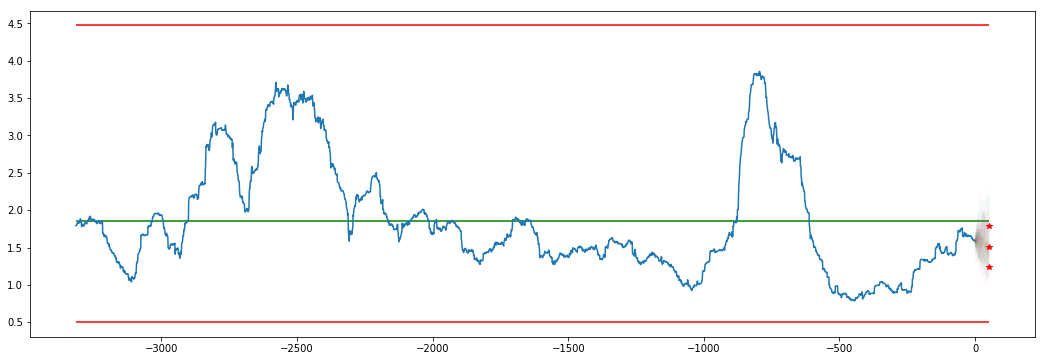

In [19]:
data = zz500
cut = 1
std_data = data.rolling(window=100).std()
new_std_data = std_data.iloc[-cut:]
old_std_data = std_data.iloc[:-cut]
all_std_data = old_std_data.dropna().copy()
all_std_data.index = range(-len(all_std_data),0)
all_std_data = all_std_data.append(new_std_data.reset_index(drop=True))
old_std_data = old_std_data.dropna().tolist()
sigma = np.std(old_std_data)*np.sqrt(252)
m = 0.2
theta_mean = np.mean(old_std_data)
theta_min = max(np.min(old_std_data) - m * (np.max(old_std_data) - np.min(old_std_data)), volatility_data_min)
theta_max = min(np.max(old_std_data) + m * (np.max(old_std_data) - np.min(old_std_data)), volatility_data_max)
k = 2.5
plt.figure(figsize=(18,6))
plt.plot(all_std_data)
ending_vol = []
forecast_days = 50
plt.hlines(theta_mean,all_std_data.index.min(),forecast_days,'g')
plt.hlines(theta_max,all_std_data.index.min(),forecast_days,'r')
plt.hlines(theta_min,all_std_data.index.min(),forecast_days,'r')
for j in range(100):
    V_0 = new_std_data.iloc[0]
    V_n1 = old_std_data[-1]
    V_list = [V_n1,V_0]
    dt = 1/252

    for i in range(forecast_days):
        V_old_old = V_list[-2]
        V_old = V_list[-1]

        choice = random.randint(0,1)
        jump = random.randint(0,99)

        m = 0.2
        theta_min = max(np.min(old_std_data + V_list) - m * (np.max(old_std_data + V_list)\
                                                             - np.min(old_std_data + V_list)), volatility_data_min)
        theta_max = min(np.max(old_std_data + V_list) + m * (np.max(old_std_data + V_list)\
                                                             - np.min(old_std_data + V_list)), volatility_data_max)

        dist_to_max = (theta_max - max(V_old,theta_min))/(theta_max - theta_min)
        dist_to_min = (min(V_old,theta_max) - theta_min)/(theta_max - theta_min)
        dist_max_mid = (theta_max - theta_mean)/(theta_max - theta_min)
        dist_min_mid = (theta_mean - theta_min)/(theta_max - theta_min)

        if choice == 0:
            V_new = V_old +\
                np.abs(dist_to_max - dist_max_mid) * np.abs(dist_to_min - dist_min_mid) * (theta_mean - V_old) * dt * 4 * k+\
                (dist_to_max * dist_to_min) * (V_old - V_old_old) * dt * 4 * k +\
                sigma * (dist_to_max * dist_to_min * 100) * V_old * dt * k * k * dt
        else:
            V_new = V_old +\
                np.abs(dist_to_max - dist_max_mid) * np.abs(dist_to_min - dist_min_mid) * (theta_mean - V_old) * dt * 4 * k +\
                (dist_to_max * dist_to_min) * (V_old - V_old_old) * dt * 4 * k -\
                sigma * (dist_to_max * dist_to_min * 100) * V_old * dt * k * k * dt

        if jump == 0:
            jump_value = interval_to_percentage_distribution_df[next(col for col in interval_to_percentage_distribution_df\
                .columns if col>dist_to_min)].loc[0]
        elif jump == 1:
            jump_value = interval_to_percentage_distribution_df[next(col for col in interval_to_percentage_distribution_df\
                .columns if col>dist_to_min)].loc[n_interval-1]
        else:
            jump_value = 0

        V_new += jump_value

        V_list.append(V_new)
    ending_vol.append(V_new)
    plt.plot(V_list,alpha=.02)
plt.plot(forecast_days+1,np.mean(ending_vol),'r*')
plt.plot(forecast_days+1,min(np.max(ending_vol),np.mean(ending_vol) + 1 * np.std(ending_vol)),'r*')
plt.plot(forecast_days+1,max(np.min(ending_vol),np.mean(ending_vol) - 1 * np.std(ending_vol)),'r*')
plt.show()

In [20]:
os.chdir(r'F:\金湖回测系统\6日循环\结果存放文件夹')
file = pd.read_excel('.\\回测_2_(C3_C3)_5000万_7_50支.xlsx').iloc[:,0]
ret = file.diff()
ret.iloc[0] = file.iloc[0]
ret = ret * 100

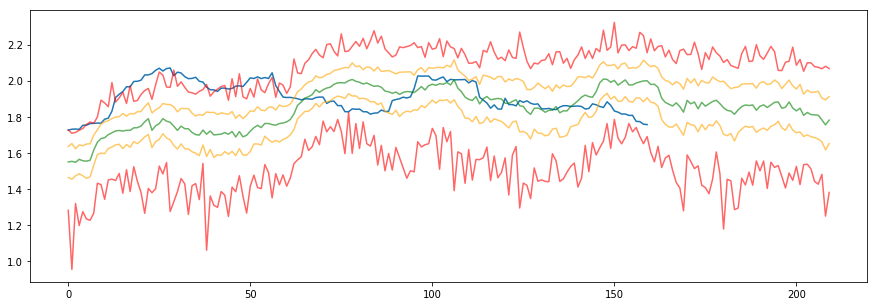

In [21]:
data = ret
std_data = data.rolling(window=100).std()

band_up = []
band_low = []
band_up_lim = []
band_low_lim = []
band_mid = []
for cut in range(len(data)-100,0,-1):
    new_std_data = std_data.iloc[-cut:]
    old_std_data = std_data.iloc[:-cut]
    all_std_data = old_std_data.dropna().copy()
    all_std_data.index = range(-len(all_std_data),0)
    all_std_data = all_std_data.append(new_std_data.reset_index(drop=True))
    old_std_data = old_std_data.dropna().tolist()
    sigma = np.std(old_std_data)*np.sqrt(252)
    m = 0.2
    theta_mean = np.mean(old_std_data)
    theta_min = max(np.min(old_std_data) - m * (np.max(old_std_data) - np.min(old_std_data)), volatility_data_min)
    theta_max = min(np.max(old_std_data) + m * (np.max(old_std_data) - np.min(old_std_data)), volatility_data_max)
    k = 2.5
    ending_vol = []
    forecast_days = 50
    for j in range(100):
        V_0 = new_std_data.iloc[0]
        V_n1 = old_std_data[-1]
        V_list = [V_n1,V_0]
        dt = 1/252

        for i in range(forecast_days):
            V_old_old = V_list[-2]
            V_old = V_list[-1]

            choice = random.randint(0,1)
            jump = random.randint(0,99)

            m = 0.2
            theta_min = max(np.min(old_std_data + V_list) - m * (np.max(old_std_data + V_list)\
                                                                 - np.min(old_std_data + V_list)), volatility_data_min)
            theta_max = min(np.max(old_std_data + V_list) + m * (np.max(old_std_data + V_list)\
                                                                 - np.min(old_std_data + V_list)), volatility_data_max)

            dist_to_max = (theta_max - max(V_old,theta_min))/(theta_max - theta_min)
            dist_to_min = (min(V_old,theta_max) - theta_min)/(theta_max - theta_min)
            dist_max_mid = (theta_max - theta_mean)/(theta_max - theta_min)
            dist_min_mid = (theta_mean - theta_min)/(theta_max - theta_min)

            if choice == 0:
                V_new = V_old +\
                    np.abs(dist_to_max - dist_max_mid) * np.abs(dist_to_min - dist_min_mid) * (theta_mean - V_old) * dt * 4 * k+\
                    (dist_to_max * dist_to_min) * (V_old - V_old_old) * dt * 4 * k +\
                    sigma * (dist_to_max * dist_to_min * 100) * V_old * dt * k * k * dt
            else:
                V_new = V_old +\
                    np.abs(dist_to_max - dist_max_mid) * np.abs(dist_to_min - dist_min_mid) * (theta_mean - V_old) * dt * 4 * k +\
                    (dist_to_max * dist_to_min) * (V_old - V_old_old) * dt * 4 * k -\
                    sigma * (dist_to_max * dist_to_min * 100) * V_old * dt * k * k * dt
                    
            if jump == 0:
                jump_value = interval_to_percentage_distribution_df[next(col for col in interval_to_percentage_distribution_df\
                    .columns if col>=dist_to_min)].loc[0]
            elif jump == 1:
                jump_value = interval_to_percentage_distribution_df[next(col for col in interval_to_percentage_distribution_df\
                    .columns if col>=dist_to_min)].loc[n_interval-1]
            else:
                jump_value = 0

            V_new += jump_value

            V_list.append(V_new)
        ending_vol.append(V_new)
    band_mid.append(np.mean(ending_vol))
    band_up.append(np.max(ending_vol))
    band_low.append(np.min(ending_vol))
    band_up_lim.append(min(np.max(ending_vol),np.mean(ending_vol) + 1 * np.std(ending_vol)))
    band_low_lim.append(max(np.min(ending_vol),np.mean(ending_vol) - 1 * np.std(ending_vol)))
plt.figure(figsize=(15,5))
plt.plot(std_data.iloc[-(len(data)-(100 + forecast_days)):].tolist())
plt.plot(band_mid,'g',alpha = 0.6)
plt.plot(band_up,'r',alpha = 0.6)
plt.plot(band_low,'r',alpha = 0.6)
plt.plot(band_up_lim,'orange',alpha = 0.6)
plt.plot(band_low_lim,'orange',alpha = 0.6)
plt.show()